In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Phase 1: Exploratory Data Analysis (EDA)

**Goal:** Understand the three healthcare datasets before building the record linkage system.

**Datasets:**
- PECOS: Medicare provider enrollment data
- Medicare: Provider utilization and payment data
- Open Payments: Pharmaceutical/device manufacturer payments to providers

**Key Questions:**
1. What fields are available for matching?
2. How much overlap exists between datasets (via NPI)?
3. What data quality issues need preprocessing?


In [2]:
medicare_path = "../data/MUP_PHY_R25_P05_V20_D23_Prov_Svc.csv"
open_payments_path = "../data/OP_DTL_GNRL_PGYR2023_P01232026_01102026.csv"
pecos_path = "../data/Medicare_FFS_Public_Provider_Enrollment_Q3_2025.csv"

In [3]:
pecos_df = pd.read_csv(pecos_path, low_memory=False, encoding='latin')
print(f"  PECOS: {len(pecos_df):,} rows, {len(pecos_df.columns)} columns")
print(pecos_df.columns)

  PECOS: 2,936,748 rows, 11 columns
Index(['NPI', 'MULTIPLE_NPI_FLAG', 'PECOS_ASCT_CNTL_ID', 'ENRLMT_ID',
       'PROVIDER_TYPE_CD', 'PROVIDER_TYPE_DESC', 'STATE_CD', 'FIRST_NAME',
       'MDL_NAME', 'LAST_NAME', 'ORG_NAME'],
      dtype='object')


In [4]:
medicare_df = pd.read_csv(medicare_path, low_memory=False)
print(f"  Medicare: {len(medicare_df):,} rows, {len(medicare_df.columns)} columns")
print(medicare_df.columns)

  Medicare: 9,660,647 rows, 28 columns
Index(['Rndrng_NPI', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name',
       'Rndrng_Prvdr_MI', 'Rndrng_Prvdr_Crdntls', 'Rndrng_Prvdr_Ent_Cd',
       'Rndrng_Prvdr_St1', 'Rndrng_Prvdr_St2', 'Rndrng_Prvdr_City',
       'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_State_FIPS',
       'Rndrng_Prvdr_Zip5', 'Rndrng_Prvdr_RUCA', 'Rndrng_Prvdr_RUCA_Desc',
       'Rndrng_Prvdr_Cntry', 'Rndrng_Prvdr_Type',
       'Rndrng_Prvdr_Mdcr_Prtcptg_Ind', 'HCPCS_Cd', 'HCPCS_Desc',
       'HCPCS_Drug_Ind', 'Place_Of_Srvc', 'Tot_Benes', 'Tot_Srvcs',
       'Tot_Bene_Day_Srvcs', 'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt',
       'Avg_Mdcr_Pymt_Amt', 'Avg_Mdcr_Stdzd_Amt'],
      dtype='object')


In [5]:
# Only read first 5,000 rows (adjust as needed)
sample_df = pd.read_csv(open_payments_path, nrows=5000)
print(f"Sample loaded: {len(sample_df):,} rows, {len(sample_df.columns)} columns")
print(sample_df.columns.to_list())  # list all columns


Sample loaded: 5,000 rows, 91 columns
['Change_Type', 'Covered_Recipient_Type', 'Teaching_Hospital_CCN', 'Teaching_Hospital_ID', 'Teaching_Hospital_Name', 'Covered_Recipient_Profile_ID', 'Covered_Recipient_NPI', 'Covered_Recipient_First_Name', 'Covered_Recipient_Middle_Name', 'Covered_Recipient_Last_Name', 'Covered_Recipient_Name_Suffix', 'Recipient_Primary_Business_Street_Address_Line1', 'Recipient_Primary_Business_Street_Address_Line2', 'Recipient_City', 'Recipient_State', 'Recipient_Zip_Code', 'Recipient_Country', 'Recipient_Province', 'Recipient_Postal_Code', 'Covered_Recipient_Primary_Type_1', 'Covered_Recipient_Primary_Type_2', 'Covered_Recipient_Primary_Type_3', 'Covered_Recipient_Primary_Type_4', 'Covered_Recipient_Primary_Type_5', 'Covered_Recipient_Primary_Type_6', 'Covered_Recipient_Specialty_1', 'Covered_Recipient_Specialty_2', 'Covered_Recipient_Specialty_3', 'Covered_Recipient_Specialty_4', 'Covered_Recipient_Specialty_5', 'Covered_Recipient_Specialty_6', 'Covered_Recipie

In [6]:
use_cols = [
    "Covered_Recipient_Profile_ID",  # Physician Profile ID
    "Covered_Recipient_First_Name",
    "Covered_Recipient_Last_Name",
    "Recipient_Primary_Business_Street_Address_Line1",
    "Recipient_City",
    "Recipient_State",
    "Recipient_Zip_Code",
    "Covered_Recipient_NPI",  # may be missing
    "Total_Amount_of_Payment_USDollars",
    "Date_of_Payment",
    "Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name",
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name",
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State",
    "Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country",
    "Program_Year"
]


In [7]:
chunk_list = []
for chunk in pd.read_csv(open_payments_path, usecols=use_cols, chunksize=200_000):
    # Optional: filter, clean, or sample chunk here
    chunk_list.append(chunk)

# Concatenate after all chunks are collected
open_payments_df = pd.concat(chunk_list, ignore_index=True)
print(f"Loaded dataset: {len(open_payments_df):,} rows, {len(open_payments_df.columns)} columns")




C:\Users\shubh\AppData\Local\Temp\ipykernel_42388\2386880916.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(open_payments_path, usecols=use_cols, chunksize=200_000):
C:\Users\shubh\AppData\Local\Temp\ipykernel_42388\2386880916.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(open_payments_path, usecols=use_cols, chunksize=200_000):
C:\Users\shubh\AppData\Local\Temp\ipykernel_42388\2386880916.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(open_payments_path, usecols=use_cols, chunksize=200_000):
C:\Users\shubh\AppData\Local\Temp\ipykernel_42388\2386880916.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(open_payments_path, usecols=use_cols, chunksiz

Loaded dataset: 14,700,786 rows, 15 columns


In [8]:
open_payments_df.columns

Index(['Covered_Recipient_Profile_ID', 'Covered_Recipient_NPI',
       'Covered_Recipient_First_Name', 'Covered_Recipient_Last_Name',
       'Recipient_Primary_Business_Street_Address_Line1', 'Recipient_City',
       'Recipient_State', 'Recipient_Zip_Code',
       'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
       'Total_Amount_of_Payment_USDollars', 'Date_of_Payment', 'Program_Year'],
      dtype='object')

In [9]:
# =============================================================================
# STATUS CHECK - All Datasets
# =============================================================================

print("=" * 70)
print("DATA LOADING STATUS")
print("=" * 70)

print(f"\n{'Dataset':<25} {'Rows':>15} {'Columns':>10}")
print("-" * 50)
print(f"{'PECOS':<25} {len(pecos_df):>15,} {len(pecos_df.columns):>10}")
print(f"{'Medicare':<25} {len(medicare_df):>15,} {len(medicare_df.columns):>10}")
print(f"{'Open Payments':<25} {len(open_payments_df):>15,} {len(open_payments_df.columns):>10}")
print("-" * 50)
total = len(pecos_df) + len(medicare_df) + len(open_payments_df)
print(f"{'TOTAL':<25} {total:>15,}")

print("\n\nOpen Payments Columns Loaded:")
print(open_payments_df.columns.tolist())


DATA LOADING STATUS

Dataset                              Rows    Columns
--------------------------------------------------
PECOS                           2,936,748         11
Medicare                        9,660,647         28
Open Payments                  14,700,786         15
--------------------------------------------------
TOTAL                          27,298,181


Open Payments Columns Loaded:
['Covered_Recipient_Profile_ID', 'Covered_Recipient_NPI', 'Covered_Recipient_First_Name', 'Covered_Recipient_Last_Name', 'Recipient_Primary_Business_Street_Address_Line1', 'Recipient_City', 'Recipient_State', 'Recipient_Zip_Code', 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Total_Amount_of_Payment_USDollars', 'Date_of_Payment', 'Program_Year']


## Part 1: Dataset Overview

In [10]:
# =============================================================================
# PART 1: DATASET OVERVIEW & SCHEMA
# =============================================================================

print("=" * 70)
print("PART 1: DATASET OVERVIEW & SCHEMA")
print("=" * 70)

# 1.1 Dataset Dimensions & Memory
print("\n1.1 DATASET DIMENSIONS & MEMORY")
print("-" * 60)

pecos_mem = pecos_df.memory_usage(deep=True).sum() / (1024**2)
medicare_mem = medicare_df.memory_usage(deep=True).sum() / (1024**2)
op_mem = open_payments_df.memory_usage(deep=True).sum() / (1024**2)

print(f"\n{'Dataset':<20} {'Rows':>15} {'Columns':>10} {'Memory (MB)':>15}")
print("-" * 60)
print(f"{'PECOS':<20} {len(pecos_df):>15,} {len(pecos_df.columns):>10} {pecos_mem:>15.1f}")
print(f"{'Medicare':<20} {len(medicare_df):>15,} {len(medicare_df.columns):>10} {medicare_mem:>15.1f}")
print(f"{'Open Payments':<20} {len(open_payments_df):>15,} {len(open_payments_df.columns):>10} {op_mem:>15.1f}")
print("-" * 60)
print(f"{'TOTAL':<20} {len(pecos_df)+len(medicare_df)+len(open_payments_df):>15,} {'':<10} {pecos_mem+medicare_mem+op_mem:>15.1f}")


PART 1: DATASET OVERVIEW & SCHEMA

1.1 DATASET DIMENSIONS & MEMORY
------------------------------------------------------------

Dataset                         Rows    Columns     Memory (MB)
------------------------------------------------------------
PECOS                      2,936,748         11          1415.0
Medicare                   9,660,647         28         11188.0
Open Payments             14,700,786         15          9620.6
------------------------------------------------------------
TOTAL                     27,298,181                    22223.5


In [11]:
# 1.2 PECOS SCHEMA (with percentages)
print("\n1.2 PECOS SCHEMA")
print("-" * 85)
print(f"{'Column':<25} {'Type':<12} {'Non-Null':>12} {'%':>8} {'Unique':>12}")
print("-" * 85)
for col in pecos_df.columns:
    non_null = pecos_df[col].notna().sum()
    pct = non_null / len(pecos_df) * 100
    unique = pecos_df[col].nunique()
    dtype = str(pecos_df[col].dtype)[:10]
    print(f"{col:<25} {dtype:<12} {non_null:>12,} {pct:>7.1f}% {unique:>12,}")



1.2 PECOS SCHEMA
-------------------------------------------------------------------------------------
Column                    Type             Non-Null        %       Unique
-------------------------------------------------------------------------------------
NPI                       int64           2,936,748   100.0%    2,521,536
MULTIPLE_NPI_FLAG         object          2,936,748   100.0%            2
PECOS_ASCT_CNTL_ID        int64           2,936,748   100.0%    2,435,588
ENRLMT_ID                 object          2,936,748   100.0%    2,936,748
PROVIDER_TYPE_CD          object          2,936,748   100.0%          325
PROVIDER_TYPE_DESC        object          2,936,748   100.0%          325
STATE_CD                  object          2,936,748   100.0%           56
FIRST_NAME                object          2,502,346    85.2%      137,422
MDL_NAME                  object          1,573,530    53.6%       68,493
LAST_NAME                 object          2,502,310    85.2%      407,

In [12]:
# 1.3 MEDICARE SCHEMA (with percentages)
print("\n1.3 MEDICARE SCHEMA")
print("-" * 90)
print(f"{'Column':<35} {'Type':<12} {'Non-Null':>12} {'%':>8} {'Unique':>12}")
print("-" * 90)
for col in medicare_df.columns:
    non_null = medicare_df[col].notna().sum()
    pct = non_null / len(medicare_df) * 100
    unique = medicare_df[col].nunique()
    dtype = str(medicare_df[col].dtype)[:10]
    print(f"{col:<35} {dtype:<12} {non_null:>12,} {pct:>7.1f}% {unique:>12,}")



1.3 MEDICARE SCHEMA
------------------------------------------------------------------------------------------
Column                              Type             Non-Null        %       Unique
------------------------------------------------------------------------------------------
Rndrng_NPI                          int64           9,660,647   100.0%    1,175,281
Rndrng_Prvdr_Last_Org_Name          object          9,660,647   100.0%      285,735
Rndrng_Prvdr_First_Name             object          9,123,548    94.4%       81,125
Rndrng_Prvdr_MI                     object          6,271,539    64.9%           32
Rndrng_Prvdr_Crdntls                object          8,580,187    88.8%       17,375
Rndrng_Prvdr_Ent_Cd                 object          9,660,647   100.0%            2
Rndrng_Prvdr_St1                    object          9,660,647   100.0%      418,342
Rndrng_Prvdr_St2                    object          2,307,128    23.9%       53,859
Rndrng_Prvdr_City                   objec

In [13]:
# 1.4 OPEN PAYMENTS SCHEMA (with percentages)
print("\n1.4 OPEN PAYMENTS SCHEMA")
print("-" * 100)
print(f"{'Column':<55} {'Type':<10} {'Non-Null':>12} {'%':>7} {'Unique':>10}")
print("-" * 100)
for col in open_payments_df.columns:
    non_null = open_payments_df[col].notna().sum()
    pct = non_null / len(open_payments_df) * 100
    unique = open_payments_df[col].nunique()
    dtype = str(open_payments_df[col].dtype)[:8]
    print(f"{col:<55} {dtype:<10} {non_null:>12,} {pct:>6.1f}% {unique:>10,}")



1.4 OPEN PAYMENTS SCHEMA
----------------------------------------------------------------------------------------------------
Column                                                  Type           Non-Null       %     Unique
----------------------------------------------------------------------------------------------------
Covered_Recipient_Profile_ID                            float64      14,669,386   99.8%    938,292
Covered_Recipient_NPI                                   float64      14,656,553   99.7%    933,619
Covered_Recipient_First_Name                            object       14,669,288   99.8%     97,757
Covered_Recipient_Last_Name                             object       14,669,035   99.8%    290,120
Recipient_Primary_Business_Street_Address_Line1         object       14,700,739  100.0%    739,987
Recipient_City                                          object       14,700,785  100.0%     22,631
Recipient_State                                         object       14,700,169

## Part 2: Missing Value Analysis

Identifies which fields have missing data. Critical for linkage because:
- Fields with high missing rates cannot be primary match keys
- Missing patterns reveal entity types (e.g., FIRST_NAME missing = organization, not individual)


In [14]:
# =============================================================================
# PART 2: MISSING VALUE ANALYSIS
# =============================================================================

print("=" * 70)
print("PART 2: MISSING VALUE ANALYSIS")
print("=" * 70)

# 2.1 PECOS Missing Values
print("\n2.1 PECOS MISSING VALUES")
print("-" * 60)
print(f"{'Column':<25} {'Missing':>12} {'Missing %':>12}")
print("-" * 60)
for col in pecos_df.columns:
    missing = pecos_df[col].isna().sum()
    pct = missing / len(pecos_df) * 100
    print(f"{col:<25} {missing:>12,} {pct:>11.2f}%")


PART 2: MISSING VALUE ANALYSIS

2.1 PECOS MISSING VALUES
------------------------------------------------------------
Column                         Missing    Missing %
------------------------------------------------------------
NPI                                  0        0.00%
MULTIPLE_NPI_FLAG                    0        0.00%
PECOS_ASCT_CNTL_ID                   0        0.00%
ENRLMT_ID                            0        0.00%
PROVIDER_TYPE_CD                     0        0.00%
PROVIDER_TYPE_DESC                   0        0.00%
STATE_CD                             0        0.00%
FIRST_NAME                     434,402       14.79%
MDL_NAME                     1,363,218       46.42%
LAST_NAME                      434,438       14.79%
ORG_NAME                     2,502,376       85.21%


In [15]:
# 2.2 Medicare Missing Values
print("\n2.2 MEDICARE MISSING VALUES")
print("-" * 60)
print(f"{'Column':<35} {'Missing':>12} {'Missing %':>12}")
print("-" * 60)
for col in medicare_df.columns:
    missing = medicare_df[col].isna().sum()
    pct = missing / len(medicare_df) * 100
    print(f"{col:<35} {missing:>12,} {pct:>11.2f}%")



2.2 MEDICARE MISSING VALUES
------------------------------------------------------------
Column                                   Missing    Missing %
------------------------------------------------------------
Rndrng_NPI                                     0        0.00%
Rndrng_Prvdr_Last_Org_Name                     0        0.00%
Rndrng_Prvdr_First_Name                  537,099        5.56%
Rndrng_Prvdr_MI                        3,389,108       35.08%
Rndrng_Prvdr_Crdntls                   1,080,460       11.18%
Rndrng_Prvdr_Ent_Cd                            0        0.00%
Rndrng_Prvdr_St1                               0        0.00%
Rndrng_Prvdr_St2                       7,353,519       76.12%
Rndrng_Prvdr_City                              0        0.00%
Rndrng_Prvdr_State_Abrvtn                      0        0.00%
Rndrng_Prvdr_State_FIPS                        5        0.00%
Rndrng_Prvdr_Zip5                              1        0.00%
Rndrng_Prvdr_RUCA                          

In [16]:
# 2.3 Open Payments Missing Values
print("\n2.3 OPEN PAYMENTS MISSING VALUES")
print("-" * 80)
print(f"{'Column':<55} {'Missing':>12} {'Missing %':>10}")
print("-" * 80)
for col in open_payments_df.columns:
    missing = open_payments_df[col].isna().sum()
    pct = missing / len(open_payments_df) * 100
    print(f"{col:<55} {missing:>12,} {pct:>9.2f}%")



2.3 OPEN PAYMENTS MISSING VALUES
--------------------------------------------------------------------------------
Column                                                       Missing  Missing %
--------------------------------------------------------------------------------
Covered_Recipient_Profile_ID                                  31,400      0.21%
Covered_Recipient_NPI                                         44,233      0.30%
Covered_Recipient_First_Name                                  31,498      0.21%
Covered_Recipient_Last_Name                                   31,751      0.22%
Recipient_Primary_Business_Street_Address_Line1                   47      0.00%
Recipient_City                                                     1      0.00%
Recipient_State                                                  617      0.00%
Recipient_Zip_Code                                               617      0.00%
Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name            0      0.00%
Ap

In [17]:
# 2.4 Missing Value Pattern Analysis
print("\n2.4 MISSING VALUE PATTERNS")
print("-" * 60)

# PECOS: Individual vs Organization pattern
print("\nPECOS - Entity Type Pattern:")
has_first = pecos_df['FIRST_NAME'].notna().sum()
has_org = pecos_df['ORG_NAME'].notna().sum()
print(f"  Records with FIRST_NAME (Individuals): {has_first:,} ({has_first/len(pecos_df)*100:.1f}%)")
print(f"  Records with ORG_NAME (Organizations):  {has_org:,} ({has_org/len(pecos_df)*100:.1f}%)")

both = ((pecos_df['FIRST_NAME'].notna()) & (pecos_df['ORG_NAME'].notna())).sum()
neither = ((pecos_df['FIRST_NAME'].isna()) & (pecos_df['ORG_NAME'].isna())).sum()
print(f"  Records with BOTH:                      {both:,}")
print(f"  Records with NEITHER:                   {neither:,}")

# Medicare: Entity type from Ent_Cd
print("\nMedicare - Entity Type (Rndrng_Prvdr_Ent_Cd):")
ent_counts = medicare_df['Rndrng_Prvdr_Ent_Cd'].value_counts()
for ent, count in ent_counts.items():
    label = "Individual" if ent == 'I' else "Organization"
    print(f"  {ent} ({label}): {count:,} ({count/len(medicare_df)*100:.1f}%)")

# Open Payments: NPI availability
print("\nOpen Payments - NPI Availability:")
has_npi = open_payments_df['Covered_Recipient_NPI'].notna().sum()
no_npi = open_payments_df['Covered_Recipient_NPI'].isna().sum()
print(f"  Records with NPI:    {has_npi:,} ({has_npi/len(open_payments_df)*100:.2f}%)")
print(f"  Records without NPI: {no_npi:,} ({no_npi/len(open_payments_df)*100:.2f}%)")



2.4 MISSING VALUE PATTERNS
------------------------------------------------------------

PECOS - Entity Type Pattern:
  Records with FIRST_NAME (Individuals): 2,502,346 (85.2%)
  Records with ORG_NAME (Organizations):  434,372 (14.8%)
  Records with BOTH:                      0
  Records with NEITHER:                   30

Medicare - Entity Type (Rndrng_Prvdr_Ent_Cd):
  I (Individual): 9,123,559 (94.4%)
  O (Organization): 537,088 (5.6%)

Open Payments - NPI Availability:
  Records with NPI:    14,656,553 (99.70%)
  Records without NPI: 44,233 (0.30%)


### Key Finding: Missing Value Patterns & Entity Type Patterns

| Dataset | Individuals | Organizations |
|---------|-------------|---------------|
| PECOS | 85.2% | 14.8% |
| Medicare | 94.4% | 5.6% |
| Open Payments | 99.7% (has NPI) | 0.3% (no NPI) |

**Implication:** Open Payments is almost entirely individual physicians. PECOS has significant organization records that need separate handling.

**PECOS Entity Type Logic:**
- FIRST_NAME present + ORG_NAME missing → Individual provider
- FIRST_NAME missing + ORG_NAME present → Organization
- Records with BOTH: 0
- Records with NEITHER: 30

**Missingness Type:** Not Missing at Random (MNAR)

This is structural missingness by design - the field populated depends on entity type. This is not a data quality issue but an intentional schema design.

**Implication:** Must handle individuals and organizations as separate matching pipelines since they use different name fields.


## Part 3: Field Distribution Analysis

In [18]:
# =============================================================================
# PART 3: FIELD DISTRIBUTION ANALYSIS
# =============================================================================

print("=" * 70)
print("PART 3: FIELD DISTRIBUTION ANALYSIS")
print("=" * 70)

# 3.1 Key Field Cardinality
print("\n3.1 KEY FIELD CARDINALITY")
print("-" * 70)

print("\nPECOS:")
print(f"  {'Field':<25} {'Unique':>12} {'% of Rows':>12}")
print(f"  {'-'*25} {'-'*12} {'-'*12}")
for col in ['NPI', 'STATE_CD', 'PROVIDER_TYPE_CD', 'FIRST_NAME', 'LAST_NAME', 'ORG_NAME']:
    unique = pecos_df[col].nunique()
    pct = unique / len(pecos_df) * 100
    print(f"  {col:<25} {unique:>12,} {pct:>11.2f}%")

print("\nMedicare:")
print(f"  {'Field':<25} {'Unique':>12} {'% of Rows':>12}")
print(f"  {'-'*25} {'-'*12} {'-'*12}")
for col in ['Rndrng_NPI', 'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_Type', 'Rndrng_Prvdr_First_Name', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_Zip5']:
    unique = medicare_df[col].nunique()
    pct = unique / len(medicare_df) * 100
    print(f"  {col:<25} {unique:>12,} {pct:>11.2f}%")

print("\nOpen Payments:")
print(f"  {'Field':<35} {'Unique':>12} {'% of Rows':>12}")
print(f"  {'-'*35} {'-'*12} {'-'*12}")
for col in ['Covered_Recipient_NPI', 'Covered_Recipient_Profile_ID', 'Recipient_State', 'Covered_Recipient_First_Name', 'Covered_Recipient_Last_Name']:
    unique = open_payments_df[col].nunique()
    pct = unique / len(open_payments_df) * 100
    print(f"  {col:<35} {unique:>12,} {pct:>11.2f}%")


PART 3: FIELD DISTRIBUTION ANALYSIS

3.1 KEY FIELD CARDINALITY
----------------------------------------------------------------------

PECOS:
  Field                           Unique    % of Rows
  ------------------------- ------------ ------------
  NPI                          2,521,536       85.86%
  STATE_CD                            56        0.00%
  PROVIDER_TYPE_CD                   325        0.01%
  FIRST_NAME                     137,422        4.68%
  LAST_NAME                      407,686       13.88%
  ORG_NAME                       289,693        9.86%

Medicare:
  Field                           Unique    % of Rows
  ------------------------- ------------ ------------
  Rndrng_NPI                   1,175,281       12.17%
  Rndrng_Prvdr_State_Abrvtn           62        0.00%
  Rndrng_Prvdr_Type                  104        0.00%
  Rndrng_Prvdr_First_Name         81,125        0.84%
  Rndrng_Prvdr_Last_Org_Name      285,735        2.96%
  Rndrng_Prvdr_Zip5               20

In [19]:
# 3.2 State Distribution
print("\n3.2 STATE DISTRIBUTION")
print("-" * 70)

print("\nPECOS - Top 10 States:")
pecos_states = pecos_df['STATE_CD'].value_counts().head(10)
for state, count in pecos_states.items():
    print(f"  {state}: {count:,} ({count/len(pecos_df)*100:.1f}%)")

print("\nMedicare - Top 10 States:")
medicare_states = medicare_df['Rndrng_Prvdr_State_Abrvtn'].value_counts().head(10)
for state, count in medicare_states.items():
    print(f"  {state}: {count:,} ({count/len(medicare_df)*100:.1f}%)")

print("\nOpen Payments - Top 10 States:")
op_states = open_payments_df['Recipient_State'].value_counts().head(10)
for state, count in op_states.items():
    print(f"  {state}: {count:,} ({count/len(open_payments_df)*100:.1f}%)")



3.2 STATE DISTRIBUTION
----------------------------------------------------------------------

PECOS - Top 10 States:
  CA: 259,154 (8.8%)
  TX: 203,519 (6.9%)
  NY: 196,409 (6.7%)
  FL: 182,248 (6.2%)
  PA: 127,384 (4.3%)
  OH: 108,290 (3.7%)
  IL: 107,984 (3.7%)
  MI: 98,217 (3.3%)
  NC: 93,331 (3.2%)
  NJ: 83,417 (2.8%)

Medicare - Top 10 States:
  CA: 809,374 (8.4%)
  FL: 702,877 (7.3%)
  TX: 671,400 (6.9%)
  NY: 617,734 (6.4%)
  PA: 438,306 (4.5%)
  IL: 391,850 (4.1%)
  OH: 346,255 (3.6%)
  NC: 343,317 (3.6%)
  NJ: 315,594 (3.3%)
  MI: 285,743 (3.0%)

Open Payments - Top 10 States:
  TX: 1,403,134 (9.5%)
  FL: 1,296,734 (8.8%)
  CA: 1,283,608 (8.7%)
  NY: 977,056 (6.6%)
  PA: 642,637 (4.4%)
  OH: 582,513 (4.0%)
  GA: 560,269 (3.8%)
  NC: 521,969 (3.6%)
  IL: 497,465 (3.4%)
  TN: 477,652 (3.2%)


In [20]:
# 3.3 Provider Type Distribution
print("\n3.3 PROVIDER TYPE DISTRIBUTION")
print("-" * 70)

print("\nPECOS - Top 10 Provider Types:")
pecos_types = pecos_df['PROVIDER_TYPE_DESC'].value_counts().head(10)
for ptype, count in pecos_types.items():
    print(f"  {ptype[:50]:<50} {count:>10,} ({count/len(pecos_df)*100:.1f}%)")

print("\nMedicare - Top 10 Provider Types:")
medicare_types = medicare_df['Rndrng_Prvdr_Type'].value_counts().head(10)
for ptype, count in medicare_types.items():
    print(f"  {ptype[:50]:<50} {count:>10,} ({count/len(medicare_df)*100:.1f}%)")



3.3 PROVIDER TYPE DISTRIBUTION
----------------------------------------------------------------------

PECOS - Top 10 Provider Types:
  PRACTITIONER - NURSE PRACTITIONER                     394,688 (13.4%)
  PART B SUPPLIER - CLINIC/GROUP PRACTICE               237,744 (8.1%)
  PRACTITIONER - PHYSICIAN ASSISTANT                    190,535 (6.5%)
  PRACTITIONER - INTERNAL MEDICINE                      144,532 (4.9%)
  PRACTITIONER - FAMILY PRACTICE                        128,759 (4.4%)
  PRACTITIONER - PHYSICAL THERAPIST IN PRIVATE PRACT    122,614 (4.2%)
  PRACTITIONER - CLINICAL SOCIAL WORKER                  98,579 (3.4%)
  PRACTITIONER - EMERGENCY MEDICINE                      85,095 (2.9%)
  PRACTITIONER - CERTIFIED REGISTERED NURSE ANESTHET     78,417 (2.7%)
  PRACTITIONER - DIAGNOSTIC RADIOLOGY                    64,088 (2.2%)

Medicare - Top 10 Provider Types:
  Diagnostic Radiology                                1,128,876 (11.7%)
  Nurse Practitioner                           

### 3.4 Name Frequency Analysis

Examines how concentrated names are. High concentration (many "Michael Smith"s) means name alone is weak for matching - we need additional fields like NPI, state, or specialty.


In [21]:
# 3.4 Name Frequency Analysis
print("\n3.4 NAME FREQUENCY ANALYSIS")
print("-" * 70)

print("\nPECOS - Top 10 First Names:")
print(pecos_df['FIRST_NAME'].value_counts().head(10).to_string())

print("\nPECOS - Top 10 Last Names:")
print(pecos_df['LAST_NAME'].value_counts().head(10).to_string())

print("\nMedicare - Top 10 First Names:")
print(medicare_df['Rndrng_Prvdr_First_Name'].value_counts().head(10).to_string())

print("\nMedicare - Top 10 Last Names:")
print(medicare_df['Rndrng_Prvdr_Last_Org_Name'].value_counts().head(10).to_string())

# Name concentration
print("\n" + "-" * 50)
print("NAME CONCENTRATION:")
pecos_top100_first = pecos_df['FIRST_NAME'].value_counts().head(100).sum()
pecos_total_first = pecos_df['FIRST_NAME'].notna().sum()
print(f"  PECOS: Top 100 first names = {pecos_top100_first/pecos_total_first*100:.1f}% of individuals")

medicare_top100_first = medicare_df['Rndrng_Prvdr_First_Name'].value_counts().head(100).sum()
medicare_total_first = medicare_df['Rndrng_Prvdr_First_Name'].notna().sum()
print(f"  Medicare: Top 100 first names = {medicare_top100_first/medicare_total_first*100:.1f}% of records")



3.4 NAME FREQUENCY ANALYSIS
----------------------------------------------------------------------

PECOS - Top 10 First Names:
FIRST_NAME
MICHAEL        36494
DAVID          30085
JOHN           27109
JENNIFER       25626
ROBERT         22009
JAMES          21390
SARAH          17794
CHRISTOPHER    17534
MATTHEW        17390
JESSICA        16988

PECOS - Top 10 Last Names:
LAST_NAME
SMITH       13853
PATEL       12805
JOHNSON     10491
LEE          9226
MILLER       8066
WILLIAMS     7855
BROWN        7839
JONES        7263
NGUYEN       6820
DAVIS        6126

Medicare - Top 10 First Names:
Rndrng_Prvdr_First_Name
Michael        200553
David          172459
John           158695
Robert         124020
James          116295
Christopher     91525
William         89557
Mark            87427
Daniel          86307
Matthew         86259

Medicare - Top 10 Last Names:
Rndrng_Prvdr_Last_Org_Name
Patel          64006
Walgreen Co    50784
Smith          47598
Lee            37925
Johnson       

### Key Finding: Name Concentration

- Top 100 first names cover ~40% of all records
- Common names like "Michael", "David", "Patel", "Smith" appear 10,000+ times each

**Implication:** Name-only matching will produce many false positives. Must combine with NPI, state, or address for disambiguation.


## Data Quality Assessment

### 4.1 NPI Validation
NPI uses the Luhn checksum algorithm (same as credit cards). We validate a sample to confirm NPIs are mathematically correct and trustworthy as exact match keys.


In [22]:
# =============================================================================
# PART 4: DATA QUALITY ASSESSMENT
# =============================================================================

print("=" * 70)
print("PART 4: DATA QUALITY ASSESSMENT")
print("=" * 70)

# 4.1 NPI Validation (Luhn Algorithm)
print("\n4.1 NPI VALIDATION (Luhn Checksum)")
print("-" * 60)

def validate_npi(npi):
    """Validate NPI using Luhn algorithm with 80840 prefix."""
    if pd.isna(npi):
        return None
    npi_str = str(int(npi))
    if len(npi_str) != 10:
        return False
    full_number = "80840" + npi_str
    total = 0
    for i, digit in enumerate(reversed(full_number)):
        d = int(digit)
        if i % 2 == 1:
            d *= 2
            if d > 9:
                d -= 9
        total += d
    return total % 10 == 0

# Sample validation (full check is slow)
print("\nValidating NPIs (100K sample per dataset)...")

pecos_sample = pecos_df['NPI'].sample(min(100000, len(pecos_df)), random_state=42)
pecos_valid = pecos_sample.apply(validate_npi)
print(f"  PECOS: {pecos_valid.sum():,}/{len(pecos_valid):,} valid ({pecos_valid.mean()*100:.2f}%)")

medicare_sample = medicare_df['Rndrng_NPI'].sample(min(100000, len(medicare_df)), random_state=42)
medicare_valid = medicare_sample.apply(validate_npi)
print(f"  Medicare: {medicare_valid.sum():,}/{len(medicare_valid):,} valid ({medicare_valid.mean()*100:.2f}%)")

op_sample = open_payments_df['Covered_Recipient_NPI'].dropna().sample(min(100000, len(open_payments_df)), random_state=42)
op_valid = op_sample.apply(validate_npi)
print(f"  Open Payments: {op_valid.sum():,}/{len(op_valid):,} valid ({op_valid.mean()*100:.2f}%)")


PART 4: DATA QUALITY ASSESSMENT

4.1 NPI VALIDATION (Luhn Checksum)
------------------------------------------------------------

Validating NPIs (100K sample per dataset)...
  PECOS: 100,000/100,000 valid (100.00%)
  Medicare: 100,000/100,000 valid (100.00%)
  Open Payments: 100,000/100,000 valid (100.00%)


In [23]:
# 4.2 Name Quality Analysis
print("\n4.2 NAME QUALITY ANALYSIS")
print("-" * 60)

def analyze_name_quality(series, name):
    non_null = series.dropna()
    total = len(non_null)
    if total == 0:
        return
    
    issues = {
        'All uppercase': (non_null == non_null.str.upper()).sum(),
        'All lowercase': (non_null == non_null.str.lower()).sum(),
        'Mixed case': ((non_null != non_null.str.upper()) & (non_null != non_null.str.lower())).sum(),
        'Contains digits': non_null.str.contains(r'\d', regex=True, na=False).sum(),
        'Single character': (non_null.str.len() == 1).sum(),
        'Has extra spaces': non_null.str.contains(r'\s{2,}', regex=True, na=False).sum(),
    }
    
    print(f"\n{name} (n={total:,}):")
    for issue, count in issues.items():
        if count > 0:
            print(f"  {issue:<20}: {count:>10,} ({count/total*100:.2f}%)")

analyze_name_quality(pecos_df['FIRST_NAME'], "PECOS FIRST_NAME")
analyze_name_quality(pecos_df['LAST_NAME'], "PECOS LAST_NAME")
analyze_name_quality(medicare_df['Rndrng_Prvdr_First_Name'], "Medicare First Name")
analyze_name_quality(medicare_df['Rndrng_Prvdr_Last_Org_Name'], "Medicare Last/Org Name")
analyze_name_quality(open_payments_df['Covered_Recipient_First_Name'], "Open Payments First Name")
analyze_name_quality(open_payments_df['Covered_Recipient_Last_Name'], "Open Payments Last Name")



4.2 NAME QUALITY ANALYSIS
------------------------------------------------------------

PECOS FIRST_NAME (n=2,502,346):
  All uppercase       :  2,502,346 (100.00%)
  Contains digits     :          5 (0.00%)
  Single character    :        722 (0.03%)
  Has extra spaces    :         27 (0.00%)

PECOS LAST_NAME (n=2,502,310):
  All uppercase       :  2,502,310 (100.00%)
  Contains digits     :          3 (0.00%)
  Single character    :         18 (0.00%)
  Has extra spaces    :         42 (0.00%)

Medicare First Name (n=9,123,548):
  All uppercase       :     12,427 (0.14%)
  Mixed case          :  9,111,121 (99.86%)
  Single character    :      8,386 (0.09%)

Medicare Last/Org Name (n=9,660,647):
  All uppercase       :         91 (0.00%)
  Mixed case          :  9,660,556 (100.00%)
  Contains digits     :      4,157 (0.04%)
  Single character    :         59 (0.00%)

Open Payments First Name (n=14,669,288):
  All uppercase       : 14,164,541 (96.56%)
  All lowercase       :        441

In [24]:
# 4.3 Address/Location Quality
print("\n4.3 ADDRESS/LOCATION QUALITY")
print("-" * 60)

print("\nZIP Code Format Analysis:")

medicare_zip_len = medicare_df['Rndrng_Prvdr_Zip5'].astype(str).str.len().value_counts().sort_index()
print(f"\nMedicare ZIP5 lengths:")
for length, count in medicare_zip_len.items():
    print(f"  {length} chars: {count:,}")

op_zip_len = open_payments_df['Recipient_Zip_Code'].dropna().astype(str).str.split('-').str[0].str.len().value_counts().sort_index()
print(f"\nOpen Payments ZIP lengths (first part):")
for length, count in op_zip_len.head(10).items():
    print(f"  {length} chars: {count:,}")



4.3 ADDRESS/LOCATION QUALITY
------------------------------------------------------------

ZIP Code Format Analysis:

Medicare ZIP5 lengths:
  1 chars: 12
  2 chars: 1
  3 chars: 17
  4 chars: 7
  5 chars: 9,660,610

Open Payments ZIP lengths (first part):
  3 chars: 14,352
  4 chars: 137,039
  5 chars: 14,308,999
  6 chars: 16,828
  7 chars: 222,951


### Key Finding: Name Case Distribution

| Dataset | Uppercase | Mixed Case | Action |
|---------|-----------|------------|--------|
| PECOS | 100% | 0% | Already standardized |
| Medicare | 0.14% | 99.86% | Convert to UPPER |
| Open Payments | 96.56% | 3.44% | Convert to UPPER |

**Insight:** Open Payments is mostly uppercase but has a 3.44% mixed-case minority (~500K records). This suggests two different data entry pipelines within the Open Payments system. All three datasets will be normalized to UPPERCASE in Phase 2.

### Key Finding: ZIP Code Quality

| Dataset | Clean 5-digit | Needs Fixing | Issue |
|---------|--------------|--------------|-------|
| Medicare | 99.99% | 30 records | Short ZIPs (leading zeros stripped) |
| Open Payments | 97.3% | ~391K records | Mixed formats (ZIP+4, short codes) |

**Insight:** Medicare has 12 records with 1-char ZIPs and 25 with 2-4 chars - these are likely leading zeros stripped from eastern state ZIPs (e.g., "2101" should be "02101"). Open Payments has 222K records with 7-char ZIPs that don't follow the standard ZIP+4 hyphenated format.

**Preprocessing:** Left-pad short ZIPs with zeros to 5 digits. Extract first 5 chars from longer ZIPs.


## Part 5: Cross-Dataset NPI Overlap
Measures how many providers appear across multiple datasets. This directly determines the feasibility of NPI-based record linkage and sets the upper bound for match rates.


In [25]:
# =============================================================================
# PART 5: CROSS-DATASET NPI OVERLAP
# =============================================================================

print("=" * 70)
print("PART 5: CROSS-DATASET NPI OVERLAP")
print("=" * 70)

# 5.1 Unique NPI counts per dataset
print("\n5.1 UNIQUE NPI COUNTS")
print("-" * 60)

pecos_npis = set(pecos_df['NPI'].unique())
medicare_npis = set(medicare_df['Rndrng_NPI'].unique())
op_npis = set(open_payments_df['Covered_Recipient_NPI'].dropna().astype(int).unique())

print(f"  PECOS unique NPIs:         {len(pecos_npis):>12,}")
print(f"  Medicare unique NPIs:      {len(medicare_npis):>12,}")
print(f"  Open Payments unique NPIs: {len(op_npis):>12,}")

all_npis = pecos_npis | medicare_npis | op_npis
print(f"\n  Total unique NPIs (union): {len(all_npis):>12,}")


PART 5: CROSS-DATASET NPI OVERLAP

5.1 UNIQUE NPI COUNTS
------------------------------------------------------------
  PECOS unique NPIs:            2,521,536
  Medicare unique NPIs:         1,175,281
  Open Payments unique NPIs:      933,619

  Total unique NPIs (union):    2,719,106


In [26]:
# 5.2 Pairwise Overlap
print("\n5.2 PAIRWISE NPI OVERLAP")
print("-" * 60)

pecos_medicare = pecos_npis & medicare_npis
pecos_op = pecos_npis & op_npis
medicare_op = medicare_npis & op_npis
all_three = pecos_npis & medicare_npis & op_npis

print(f"\n  PECOS ∩ Medicare:         {len(pecos_medicare):>10,}  ({len(pecos_medicare)/len(pecos_npis)*100:.1f}% of PECOS, {len(pecos_medicare)/len(medicare_npis)*100:.1f}% of Medicare)")
print(f"  PECOS ∩ Open Payments:    {len(pecos_op):>10,}  ({len(pecos_op)/len(pecos_npis)*100:.1f}% of PECOS, {len(pecos_op)/len(op_npis)*100:.1f}% of OP)")
print(f"  Medicare ∩ Open Payments: {len(medicare_op):>10,}  ({len(medicare_op)/len(medicare_npis)*100:.1f}% of Medicare, {len(medicare_op)/len(op_npis)*100:.1f}% of OP)")
print(f"\n  All Three (∩):            {len(all_three):>10,}")



5.2 PAIRWISE NPI OVERLAP
------------------------------------------------------------

  PECOS ∩ Medicare:          1,138,464  (45.1% of PECOS, 96.9% of Medicare)
  PECOS ∩ Open Payments:       763,703  (30.3% of PECOS, 81.8% of OP)
  Medicare ∩ Open Payments:    542,329  (46.1% of Medicare, 58.1% of OP)

  All Three (∩):               533,166


In [27]:
# 5.3 Exclusive NPIs (appear in only one dataset)
print("\n5.3 EXCLUSIVE NPIs (appear in only one dataset)")
print("-" * 60)

only_pecos = pecos_npis - medicare_npis - op_npis
only_medicare = medicare_npis - pecos_npis - op_npis
only_op = op_npis - pecos_npis - medicare_npis

print(f"  Only in PECOS:         {len(only_pecos):>10,} ({len(only_pecos)/len(pecos_npis)*100:.1f}%)")
print(f"  Only in Medicare:      {len(only_medicare):>10,} ({len(only_medicare)/len(medicare_npis)*100:.1f}%)")
print(f"  Only in Open Payments: {len(only_op):>10,} ({len(only_op)/len(op_npis)*100:.1f}%)")

# 5.4 NPI Duplication within datasets
print("\n5.4 NPI DUPLICATION WITHIN DATASETS")
print("-" * 60)
print("  (How many rows per unique NPI - indicates 1:many relationships)")

pecos_npi_counts = pecos_df['NPI'].value_counts()
medicare_npi_counts = medicare_df['Rndrng_NPI'].value_counts()
op_npi_counts = open_payments_df['Covered_Recipient_NPI'].dropna().astype(int).value_counts()

print(f"\n  {'Metric':<30} {'PECOS':>12} {'Medicare':>12} {'Open Pay':>12}")
print(f"  {'-'*30} {'-'*12} {'-'*12} {'-'*12}")
print(f"  {'Mean rows per NPI':<30} {pecos_npi_counts.mean():>12.1f} {medicare_npi_counts.mean():>12.1f} {op_npi_counts.mean():>12.1f}")
print(f"  {'Median rows per NPI':<30} {pecos_npi_counts.median():>12.1f} {medicare_npi_counts.median():>12.1f} {op_npi_counts.median():>12.1f}")
print(f"  {'Max rows per NPI':<30} {pecos_npi_counts.max():>12,} {medicare_npi_counts.max():>12,} {op_npi_counts.max():>12,}")
print(f"  {'NPIs with 1 row':<30} {(pecos_npi_counts==1).sum():>12,} {(medicare_npi_counts==1).sum():>12,} {(op_npi_counts==1).sum():>12,}")
print(f"  {'NPIs with >10 rows':<30} {(pecos_npi_counts>10).sum():>12,} {(medicare_npi_counts>10).sum():>12,} {(op_npi_counts>10).sum():>12,}")



5.3 EXCLUSIVE NPIs (appear in only one dataset)
------------------------------------------------------------
  Only in PECOS:          1,152,535 (45.7%)
  Only in Medicare:          27,654 (2.4%)
  Only in Open Payments:    160,753 (17.2%)

5.4 NPI DUPLICATION WITHIN DATASETS
------------------------------------------------------------
  (How many rows per unique NPI - indicates 1:many relationships)

  Metric                                PECOS     Medicare     Open Pay
  ------------------------------ ------------ ------------ ------------
  Mean rows per NPI                       1.2          8.2         15.7
  Median rows per NPI                     1.0          5.0          4.0
  Max rows per NPI                         75          658        1,175
  NPIs with 1 row                   2,239,363      135,639      249,674
  NPIs with >10 rows                    2,258      262,642      280,796


### Key Finding: NPI Overlap Analysis

**High Overlap:**
- 96.9% of Medicare NPIs exist in PECOS - nearly complete coverage
- 81.8% of Open Payments NPIs exist in PECOS
- 533,166 providers appear in ALL THREE datasets

**PECOS is the superset:** Contains 2.5M unique NPIs vs 1.2M (Medicare) and 934K (Open Payments). 45.7% of PECOS NPIs appear only in PECOS - these are enrolled providers who didn't bill Medicare or receive industry payments in 2023.

**Only 2.4% of Medicare NPIs are missing from PECOS.** This small gap likely represents providers who billed Medicare but had enrollment data changes.

**NPI Duplication Pattern:**
- PECOS: ~1 row per NPI (enrollment records)
- Medicare: ~8 rows per NPI (one row per procedure billed)
- Open Payments: ~16 rows per NPI (one row per payment received)

**Implication for Linkage:**
- NPI-based exact matching can link the majority of records across datasets
- Before joining, Medicare and Open Payments must be aggregated to provider-level (deduplicated by NPI)
- 160K Open Payments NPIs not in PECOS will need fuzzy matching as fallback


## Part 6: Temporal Analysis

In [28]:
# =============================================================================
# PART 6: TEMPORAL ANALYSIS
# =============================================================================

print("=" * 70)
print("PART 6: TEMPORAL ANALYSIS")
print("=" * 70)

# 6.1 Open Payments Date Distribution
print("\n6.1 OPEN PAYMENTS - PAYMENT DATE DISTRIBUTION")
print("-" * 60)

op_dates = pd.to_datetime(open_payments_df['Date_of_Payment'], format='%m/%d/%Y')
print(f"  Date Range: {op_dates.min()} to {op_dates.max()}")
print(f"  Program Year: {open_payments_df['Program_Year'].unique()}")

monthly = op_dates.dt.to_period('M').value_counts().sort_index()
print(f"\n  Monthly Distribution:")
for month, count in monthly.items():
    bar = '#' * int(count / monthly.max() * 40)
    print(f"    {month}: {count:>10,} {bar}")


PART 6: TEMPORAL ANALYSIS

6.1 OPEN PAYMENTS - PAYMENT DATE DISTRIBUTION
------------------------------------------------------------
  Date Range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
  Program Year: [2023]

  Monthly Distribution:
    2023-01:  1,079,575 ###############################
    2023-02:  1,176,703 ##################################
    2023-03:  1,377,310 ########################################
    2023-04:  1,215,550 ###################################
    2023-05:  1,358,254 #######################################
    2023-06:  1,262,081 ####################################
    2023-07:  1,044,447 ##############################
    2023-08:  1,362,363 #######################################
    2023-09:  1,243,801 ####################################
    2023-10:  1,372,975 #######################################
    2023-11:  1,263,075 ####################################
    2023-12:    944,652 ###########################


In [29]:
# 6.2 PECOS - Multiple NPI Flag & Enrollment Patterns
print("\n6.2 PECOS - ENROLLMENT PATTERNS")
print("-" * 60)

print("\nMultiple NPI Flag:")
print(pecos_df['MULTIPLE_NPI_FLAG'].value_counts().to_string())

# NPI reuse - same NPI, different enrollment IDs
pecos_npi_enrollments = pecos_df.groupby('NPI')['ENRLMT_ID'].nunique()
print(f"\n  NPIs with 1 enrollment:  {(pecos_npi_enrollments == 1).sum():,}")
print(f"  NPIs with 2 enrollments: {(pecos_npi_enrollments == 2).sum():,}")
print(f"  NPIs with 3+ enrollments:{(pecos_npi_enrollments >= 3).sum():,}")
print(f"  Max enrollments per NPI: {pecos_npi_enrollments.max()}")




6.2 PECOS - ENROLLMENT PATTERNS
------------------------------------------------------------

Multiple NPI Flag:
MULTIPLE_NPI_FLAG
N    2921370
Y      15378

  NPIs with 1 enrollment:  2,239,363
  NPIs with 2 enrollments: 225,080
  NPIs with 3+ enrollments:57,093
  Max enrollments per NPI: 75


In [30]:
# 6.3 Medicare - Service Volume Distribution
print("\n6.3 MEDICARE - SERVICE VOLUME DISTRIBUTION")
print("-" * 60)

print("\nPer-NPI Aggregated Stats:")
medicare_agg = medicare_df.groupby('Rndrng_NPI').agg(
    total_services=('Tot_Srvcs', 'sum'),
    total_benes=('Tot_Benes', 'sum'),
    total_charges=('Avg_Sbmtd_Chrg', 'sum'),
    num_procedures=('HCPCS_Cd', 'nunique')
).describe()

for col in ['total_services', 'total_benes', 'num_procedures']:
    print(f"\n  {col}:")
    for stat in ['mean', '50%', 'max']:
        val = medicare_agg.loc[stat, col]
        print(f"    {stat:<8}: {val:>15,.1f}")



6.3 MEDICARE - SERVICE VOLUME DISTRIBUTION
------------------------------------------------------------

Per-NPI Aggregated Stats:

  total_services:
    mean    :         2,251.0
    50%     :           418.0
    max     :    16,019,747.0

  total_benes:
    mean    :           701.7
    50%     :           233.0
    max     :    10,403,747.0

  num_procedures:
    mean    :             7.9
    50%     :             5.0
    max     :           658.0


In [31]:
# 6.4 Open Payments - Payment Amount Distribution
print("\n6.4 OPEN PAYMENTS - PAYMENT AMOUNT DISTRIBUTION")
print("-" * 60)

amounts = open_payments_df['Total_Amount_of_Payment_USDollars']
print(f"  Total Payments: ${amounts.sum():,.2f}")
print(f"  Mean:           ${amounts.mean():,.2f}")
print(f"  Median:         ${amounts.median():,.2f}")
print(f"  Min:            ${amounts.min():,.2f}")
print(f"  Max:            ${amounts.max():,.2f}")

print(f"\n  Payment Distribution:")
bins = [0, 10, 50, 100, 500, 1000, 5000, 10000, float('inf')]
labels = ['$0-10', '$10-50', '$50-100', '$100-500', '$500-1K', '$1K-5K', '$5K-10K', '$10K+']
payment_bins = pd.cut(amounts, bins=bins, labels=labels)
for label, count in payment_bins.value_counts().sort_index().items():
    pct = count / len(amounts) * 100
    bar = '#' * int(pct)
    print(f"    {label:<12}: {count:>12,} ({pct:>5.1f}%) {bar}")



6.4 OPEN PAYMENTS - PAYMENT AMOUNT DISTRIBUTION
------------------------------------------------------------
  Total Payments: $3,314,058,093.43
  Mean:           $225.43
  Median:         $19.47
  Min:            $0.00
  Max:            $88,377,304.59

  Payment Distribution:
    $0-10       :    1,694,075 ( 11.5%) ###########
    $10-50      :   10,657,890 ( 72.5%) ########################################################################
    $50-100     :      650,483 (  4.4%) ####
    $100-500    :    1,176,185 (  8.0%) ########
    $500-1K     :      158,945 (  1.1%) #
    $1K-5K      :      300,034 (  2.0%) ##
    $5K-10K     :       41,451 (  0.3%) 
    $10K+       :       21,720 (  0.1%) 


In [32]:
# 6.2 PECOS - Hidden Temporal Signal in ENRLMT_ID
print("\n6.2 PECOS - ENROLLMENT ID TEMPORAL ANALYSIS")
print("-" * 60)

print("\nENRLMT_ID samples:")
print(pecos_df['ENRLMT_ID'].sample(20, random_state=42).tolist())

print("\nENRLMT_ID string length distribution:")
print(pecos_df['ENRLMT_ID'].str.len().value_counts().sort_index())

print("\nFirst 4 chars (possible year?):")
print(pecos_df['ENRLMT_ID'].str[:4].value_counts().sort_index().head(20))

print("\nLast 4 chars:")
print(pecos_df['ENRLMT_ID'].str[-4:].value_counts().sort_index().head(20))

print("\nMiddle segment analysis:")
# Check if there's a date pattern embedded
sample = pecos_df['ENRLMT_ID'].sample(30, random_state=42)
for val in sample:
    print(f"  {val}")



6.2 PECOS - ENROLLMENT ID TEMPORAL ANALYSIS
------------------------------------------------------------

ENRLMT_ID samples:
['I20041110000156', 'I20180316000539', 'I20050428000989', 'I20140522001281', 'I20140807002600', 'I20110127001062', 'I20050215000103', 'I20250903002500', 'I20250321001274', 'O20250603001566', 'O20100930094781', 'I20250820004468', 'I20101019001308', 'I20110415000532', 'I20240730002797', 'I20160222001519', 'I20050829000954', 'I20230209001656', 'I20090819000558', 'I20220202002583']

ENRLMT_ID string length distribution:
ENRLMT_ID
15    2936748
Name: count, dtype: int64

First 4 chars (possible year?):
ENRLMT_ID
I200     461230
I201     935685
I202    1105461
O200     104369
O201     183258
O202     146745
Name: count, dtype: int64

Last 4 chars:
ENRLMT_ID
0000    2388
0001    2224
0002    2161
0003    2099
0004    2166
0005    2215
0006    2163
0007    2218
0008    2065
0009    2124
0010    2059
0011    2081
0012    2083
0013    2045
0014    2159
0015    2125
0016  

In [33]:
# 6.2 PECOS - ENROLLMENT DATE EXTRACTION
print("\n6.2 PECOS - ENROLLMENT DATE ANALYSIS")
print("-" * 60)

# Format: [I/O][YYYYMMDD][NNNNNN]
# I = Individual, O = Organization
pecos_df['ENRLMT_ENTITY'] = pecos_df['ENRLMT_ID'].str[0]
pecos_df['ENRLMT_DATE'] = pd.to_datetime(pecos_df['ENRLMT_ID'].str[1:9], format='%Y%m%d', errors='coerce')
pecos_df['ENRLMT_YEAR'] = pecos_df['ENRLMT_DATE'].dt.year

print("\nEntity Type from ENRLMT_ID prefix:")
print(f"  I (Individual):    {(pecos_df['ENRLMT_ENTITY'] == 'I').sum():,}")
print(f"  O (Organization):  {(pecos_df['ENRLMT_ENTITY'] == 'O').sum():,}")

print(f"\nDate Range: {pecos_df['ENRLMT_DATE'].min()} to {pecos_df['ENRLMT_DATE'].max()}")
print(f"Invalid dates: {pecos_df['ENRLMT_DATE'].isna().sum():,}")

print("\nEnrollment Year Distribution:")
year_counts = pecos_df['ENRLMT_YEAR'].value_counts().sort_index()
for year, count in year_counts.items():
    bar = '#' * int(count / year_counts.max() * 40)
    print(f"  {int(year)}: {count:>10,} {bar}")



6.2 PECOS - ENROLLMENT DATE ANALYSIS
------------------------------------------------------------

Entity Type from ENRLMT_ID prefix:
  I (Individual):    2,502,376
  O (Organization):  434,372

Date Range: 2002-08-01 00:00:00 to 2025-09-13 00:00:00
Invalid dates: 0

Enrollment Year Distribution:
  2002:        472 
  2003:     15,666 #
  2004:    138,836 #################
  2005:    107,198 #############
  2006:     62,138 #######
  2007:     78,252 #########
  2008:     86,296 ##########
  2009:     76,741 #########
  2010:    167,817 #####################
  2011:    100,120 ############
  2012:     85,971 ##########
  2013:     74,984 #########
  2014:     85,617 ##########
  2015:    113,770 ##############
  2016:    129,360 ################
  2017:    111,862 ##############
  2018:    116,659 ##############
  2019:    132,783 ################
  2020:    144,434 ##################
  2021:    164,530 ####################
  2022:    185,932 #######################
  2023:    226,100

In [34]:
# Cross-validate: Entity prefix vs name fields
print("\nCROSS-VALIDATION: ENRLMT_ID prefix vs Name Fields")
print("-" * 60)

i_records = pecos_df[pecos_df['ENRLMT_ENTITY'] == 'I']
o_records = pecos_df[pecos_df['ENRLMT_ENTITY'] == 'O']

print(f"\n  'I' prefix records: {len(i_records):,}")
print(f"    Has FIRST_NAME: {i_records['FIRST_NAME'].notna().sum():,} ({i_records['FIRST_NAME'].notna().mean()*100:.2f}%)")
print(f"    Has ORG_NAME:   {i_records['ORG_NAME'].notna().sum():,} ({i_records['ORG_NAME'].notna().mean()*100:.2f}%)")

print(f"\n  'O' prefix records: {len(o_records):,}")
print(f"    Has FIRST_NAME: {o_records['FIRST_NAME'].notna().sum():,} ({o_records['FIRST_NAME'].notna().mean()*100:.2f}%)")
print(f"    Has ORG_NAME:   {o_records['ORG_NAME'].notna().sum():,} ({o_records['ORG_NAME'].notna().mean()*100:.2f}%)")



CROSS-VALIDATION: ENRLMT_ID prefix vs Name Fields
------------------------------------------------------------

  'I' prefix records: 2,502,376
    Has FIRST_NAME: 2,502,346 (100.00%)
    Has ORG_NAME:   0 (0.00%)

  'O' prefix records: 434,372
    Has FIRST_NAME: 0 (0.00%)
    Has ORG_NAME:   434,372 (100.00%)


In [35]:
# Filter to <= 2023 for temporal alignment with other datasets
print("\nTEMPORAL ALIGNMENT CHECK")
print("-" * 60)

pre_2024 = pecos_df[pecos_df['ENRLMT_YEAR'] <= 2023]
post_2023 = pecos_df[pecos_df['ENRLMT_YEAR'] > 2023]

print(f"  Enrollments <= 2023: {len(pre_2024):,} ({len(pre_2024)/len(pecos_df)*100:.1f}%)")
print(f"  Enrollments > 2023:  {len(post_2023):,} ({len(post_2023)/len(pecos_df)*100:.1f}%)")
print(f"\n  For linkage with 2023 Medicare & Open Payments data,")
print(f"  we may consider filtering to <= 2023 enrollments.")
print(f"  However, post-2023 enrollments still represent valid providers.")



TEMPORAL ALIGNMENT CHECK
------------------------------------------------------------
  Enrollments <= 2023: 2,405,538 (81.9%)
  Enrollments > 2023:  531,210 (18.1%)

  For linkage with 2023 Medicare & Open Payments data,
  we may consider filtering to <= 2023 enrollments.
  However, post-2023 enrollments still represent valid providers.


### Key Finding: PECOS Enrollment Trends

- Enrollment volume is **accelerating** - 2024 has the highest enrollment count (317K)
- 2025 already at 213K (data through Sept 13, 2025 - on pace to exceed 2024)
- Earliest enrollment: 2002 (PECOS system inception)
- This is a **cumulative registry** - providers enrolled in 2004 are still in the dataset if currently active


In [36]:
print("PECOS COLUMNS:")
print("-" * 60)
for i, col in enumerate(pecos_df.columns):
    print(f"  {i+1:>3}. {col}")
    
print(f"\nTotal columns: {len(pecos_df.columns)}")

# Check for key fields mentioned
print("\n\nKEY FIELD CHECK:")
print("-" * 60)

key_fields = {
    'NPI': 'NPI',
    'Business Name': None,
    'Practice Address': None,
    'Enrollment Date': None,
    'Provider Type': None
}

# Search for relevant columns
for col in pecos_df.columns:
    print(f"  {col}: {pecos_df[col].notna().sum():,} non-null | Sample: {pecos_df[col].dropna().head(3).tolist()}")


PECOS COLUMNS:
------------------------------------------------------------
    1. NPI
    2. MULTIPLE_NPI_FLAG
    3. PECOS_ASCT_CNTL_ID
    4. ENRLMT_ID
    5. PROVIDER_TYPE_CD
    6. PROVIDER_TYPE_DESC
    7. STATE_CD
    8. FIRST_NAME
    9. MDL_NAME
   10. LAST_NAME
   11. ORG_NAME
   12. ENRLMT_ENTITY
   13. ENRLMT_DATE
   14. ENRLMT_YEAR

Total columns: 14


KEY FIELD CHECK:
------------------------------------------------------------
  NPI: 2,936,748 non-null | Sample: [1053656744, 1578280707, 1710872676]
  MULTIPLE_NPI_FLAG: 2,936,748 non-null | Sample: ['N', 'N', 'N']
  PECOS_ASCT_CNTL_ID: 2,936,748 non-null | Sample: [3577554138, 4587167663, 6507373503]
  ENRLMT_ID: 2,936,748 non-null | Sample: ['O20250912004448', 'O20250912004380', 'O20250912004283']
  PROVIDER_TYPE_CD: 2,936,748 non-null | Sample: ['12-70', '12-70', '12-70']
  PROVIDER_TYPE_DESC: 2,936,748 non-null | Sample: ['PART B SUPPLIER - CLINIC/GROUP PRACTICE', 'PART B SUPPLIER - CLINIC/GROUP PRACTICE', 'PART B SUPP

In [37]:
print("OPEN PAYMENTS COLUMNS:")
print("-" * 60)
for i, col in enumerate(open_payments_df.columns):
    print(f"  {i+1:>3}. {col}")

print(f"\nTotal columns: {len(open_payments_df.columns)}")

print("\n\nKEY FIELD CHECK:")
print("-" * 60)
for col in open_payments_df.columns:
    non_null = open_payments_df[col].notna().sum()
    pct = non_null / len(open_payments_df) * 100
    sample = open_payments_df[col].dropna().head(3).tolist()
    print(f"  {col}: {non_null:,} ({pct:.1f}%) | Sample: {sample}")


OPEN PAYMENTS COLUMNS:
------------------------------------------------------------
    1. Covered_Recipient_Profile_ID
    2. Covered_Recipient_NPI
    3. Covered_Recipient_First_Name
    4. Covered_Recipient_Last_Name
    5. Recipient_Primary_Business_Street_Address_Line1
    6. Recipient_City
    7. Recipient_State
    8. Recipient_Zip_Code
    9. Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name
   10. Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name
   11. Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State
   12. Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country
   13. Total_Amount_of_Payment_USDollars
   14. Date_of_Payment
   15. Program_Year

Total columns: 15


KEY FIELD CHECK:
------------------------------------------------------------
  Covered_Recipient_Profile_ID: 14,669,386 (99.8%) | Sample: [760737.0, 267460.0, 1249653.0]
  Covered_Recipient_NPI: 14,656,553 (99.7%) | Sample: [1952716680.0, 1881880862.0, 1144497728.0]
  Cov

In [38]:
print("MEDICARE COLUMNS:")
print("-" * 60)
for i, col in enumerate(medicare_df.columns):
    print(f"  {i+1:>3}. {col}")

print(f"\nTotal columns: {len(medicare_df.columns)}")

print("\n\nKEY FIELD CHECK:")
print("-" * 60)
for col in medicare_df.columns:
    non_null = medicare_df[col].notna().sum()
    pct = non_null / len(medicare_df) * 100
    sample = medicare_df[col].dropna().head(3).tolist()
    print(f"  {col}: {non_null:,} ({pct:.1f}%) | Sample: {sample}")


MEDICARE COLUMNS:
------------------------------------------------------------
    1. Rndrng_NPI
    2. Rndrng_Prvdr_Last_Org_Name
    3. Rndrng_Prvdr_First_Name
    4. Rndrng_Prvdr_MI
    5. Rndrng_Prvdr_Crdntls
    6. Rndrng_Prvdr_Ent_Cd
    7. Rndrng_Prvdr_St1
    8. Rndrng_Prvdr_St2
    9. Rndrng_Prvdr_City
   10. Rndrng_Prvdr_State_Abrvtn
   11. Rndrng_Prvdr_State_FIPS
   12. Rndrng_Prvdr_Zip5
   13. Rndrng_Prvdr_RUCA
   14. Rndrng_Prvdr_RUCA_Desc
   15. Rndrng_Prvdr_Cntry
   16. Rndrng_Prvdr_Type
   17. Rndrng_Prvdr_Mdcr_Prtcptg_Ind
   18. HCPCS_Cd
   19. HCPCS_Desc
   20. HCPCS_Drug_Ind
   21. Place_Of_Srvc
   22. Tot_Benes
   23. Tot_Srvcs
   24. Tot_Bene_Day_Srvcs
   25. Avg_Sbmtd_Chrg
   26. Avg_Mdcr_Alowd_Amt
   27. Avg_Mdcr_Pymt_Amt
   28. Avg_Mdcr_Stdzd_Amt

Total columns: 28


KEY FIELD CHECK:
------------------------------------------------------------
  Rndrng_NPI: 9,660,647 (100.0%) | Sample: [1003000126, 1003000126, 1003000126]
  Rndrng_Prvdr_Last_Org_Name: 9,660,647 

In [39]:
print("OPEN PAYMENTS - ENTITY TYPE CHECK:")
print("-" * 60)

# Check if there's an entity type column
print("Columns containing 'type' or 'entity' or 'org':")
for col in open_payments_df.columns:
    if any(kw in col.lower() for kw in ['type', 'entity', 'org', 'recipient']):
        print(f"  {col}")

# Check the Covered_Recipient fields for clues
print(f"\nCovered_Recipient_Profile_ID nulls: {open_payments_df['Covered_Recipient_Profile_ID'].isna().sum():,}")
print(f"Covered_Recipient_NPI nulls: {open_payments_df['Covered_Recipient_NPI'].isna().sum():,}")
print(f"Covered_Recipient_First_Name nulls: {open_payments_df['Covered_Recipient_First_Name'].isna().sum():,}")
print(f"Covered_Recipient_Last_Name nulls: {open_payments_df['Covered_Recipient_Last_Name'].isna().sum():,}")

# Are there rows where First Name is null but Last Name exists (possible o


OPEN PAYMENTS - ENTITY TYPE CHECK:
------------------------------------------------------------
Columns containing 'type' or 'entity' or 'org':
  Covered_Recipient_Profile_ID
  Covered_Recipient_NPI
  Covered_Recipient_First_Name
  Covered_Recipient_Last_Name
  Recipient_Primary_Business_Street_Address_Line1
  Recipient_City
  Recipient_State
  Recipient_Zip_Code

Covered_Recipient_Profile_ID nulls: 31,400
Covered_Recipient_NPI nulls: 44,233
Covered_Recipient_First_Name nulls: 31,498
Covered_Recipient_Last_Name nulls: 31,751


In [40]:
print("INVESTIGATING ~31K ROWS WITH MISSING NAMES:")
print("-" * 60)

# Rows missing First Name
no_name = open_payments_df[open_payments_df['Covered_Recipient_First_Name'].isna() & 
                           open_payments_df['Covered_Recipient_Last_Name'].isna()]
print(f"Rows missing BOTH First and Last Name: {len(no_name):,}")

# What do these rows look like?
print("\nSample of rows with no names:")
print(no_name[['Covered_Recipient_Profile_ID', 'Covered_Recipient_NPI', 
               'Recipient_Primary_Business_Street_Address_Line1',
               'Recipient_City', 'Recipient_State',
               'Total_Amount_of_Payment_USDollars']].head(10).to_string())

# Rows missing First but HAVING Last (possible orgs?)
has_last_no_first = open_payments_df[open_payments_df['Covered_Recipient_First_Name'].isna() & 
                                      open_payments_df['Covered_Recipient_Last_Name'].notna()]
print(f"\nRows with Last Name but NO First Name: {len(has_last_no_first):,}")
if len(has_last_no_first) > 0:
    print("  Sample Last Names:")
    print(has_last_no_first['Covered_Recipient_Last_Name'].head(10).tolist())

# Check if the file we loaded might be "General Payments" only (not research/ownership)
print(f"\nTotal rows: {len(open_payments_df):,}")
print(f"Rows WITH both names: {len(open_payments_df) - len(no_name):,} ({(len(open_payments_df) - len(no_name))/len(open_payments_df)*100:.1f}%)")
print(f"Rows MISSING both names: {len(no_name):,} ({len(no_name)/len(open_payments_df)*100:.2f}%)")


INVESTIGATING ~31K ROWS WITH MISSING NAMES:
------------------------------------------------------------
Rows missing BOTH First and Last Name: 31,405

Sample of rows with no names:
       Covered_Recipient_Profile_ID  Covered_Recipient_NPI Recipient_Primary_Business_Street_Address_Line1 Recipient_City Recipient_State  Total_Amount_of_Payment_USDollars
11265                           NaN                    NaN                             2800 S McGregor Way        Houston              TX                            10891.1
14520                           NaN                    NaN                         303 N Clyde Morris Blvd  Daytona Beach              FL                             1400.0
14521                           NaN                    NaN                           1117 E Devonshire Ave          Hemet              CA                             1400.0
14522                           NaN                    NaN                        701 Park Ave, P1-Finance    Minneapolis     

In [41]:
print("SAME PERSON, MULTIPLE NPIs (Individual + Organization)?")
print("=" * 60)

# In PECOS: Get individual records with names
pecos_indiv = pecos_df[pecos_df['ENRLMT_ENTITY'] == 'I'][['NPI', 'FIRST_NAME', 'LAST_NAME', 'STATE_CD']].drop_duplicates(subset='NPI')
pecos_org = pecos_df[pecos_df['ENRLMT_ENTITY'] == 'O'][['NPI', 'ORG_NAME', 'STATE_CD']].drop_duplicates(subset='NPI')

print(f"Unique Individual NPIs: {len(pecos_indiv):,}")
print(f"Unique Organization NPIs: {len(pecos_org):,}")

# Check: Does any NPI appear in BOTH individual and org?
both = set(pecos_indiv['NPI']) & set(pecos_org['NPI'])
print(f"\nNPIs that are BOTH individual AND org: {len(both):,}")

# Check MULTIPLE_NPI_FLAG
print(f"\nMULTIPLE_NPI_FLAG distribution:")
print(pecos_df['MULTIPLE_NPI_FLAG'].value_counts())

# Look at providers with MULTIPLE_NPI_FLAG = 'Y'
multi_npi = pecos_df[pecos_df['MULTIPLE_NPI_FLAG'] == 'Y']
print(f"\nRecords with MULTIPLE_NPI_FLAG='Y': {len(multi_npi):,}")
print(f"Unique NPIs with flag='Y': {multi_npi['NPI'].nunique():,}")

# For those with flag=Y, do they appear as both I and O?
multi_npis = set(multi_npi['NPI'].unique())
multi_as_I = multi_npis & set(pecos_indiv['NPI'])
multi_as_O = multi_npis & set(pecos_org['NPI'])
print(f"\n  Of those, appearing as Individual: {len(multi_as_I):,}")
print(f"  Of those, appearing as Org:        {len(multi_as_O):,}")
print(f"  Appearing as BOTH I and O:         {len(multi_as_I & multi_as_O):,}")


SAME PERSON, MULTIPLE NPIs (Individual + Organization)?
Unique Individual NPIs: 2,142,466
Unique Organization NPIs: 379,645

NPIs that are BOTH individual AND org: 575

MULTIPLE_NPI_FLAG distribution:
MULTIPLE_NPI_FLAG
N    2921370
Y      15378
Name: count, dtype: int64

Records with MULTIPLE_NPI_FLAG='Y': 15,378
Unique NPIs with flag='Y': 14,345

  Of those, appearing as Individual: 0
  Of those, appearing as Org:        14,345
  Appearing as BOTH I and O:         0


In [42]:
# Now check: same person name appearing under DIFFERENT NPIs 
# (one as individual, one could be their org)
print("\nSAME NAME ACROSS DIFFERENT NPIs:")
print("-" * 60)

# Look at PECOS_ASCT_CNTL_ID - this might link a person to their org
print("\nPECOS_ASCT_CNTL_ID (Associate Control ID) analysis:")
assoc_per_npi = pecos_df.groupby('NPI')['PECOS_ASCT_CNTL_ID'].nunique()
print(f"  NPIs with 1 ASCT_CNTL_ID:  {(assoc_per_npi == 1).sum():,}")
print(f"  NPIs with 2+ ASCT_CNTL_ID: {(assoc_per_npi > 1).sum():,}")

# Flip: same ASCT_CNTL_ID across multiple NPIs?
npi_per_assoc = pecos_df.groupby('PECOS_ASCT_CNTL_ID')['NPI'].nunique()
print(f"\n  ASCT_CNTL_IDs linked to 1 NPI:  {(npi_per_assoc == 1).sum():,}")
print(f"  ASCT_CNTL_IDs linked to 2+ NPIs: {(npi_per_assoc > 1).sum():,}")

multi_npi_assoc = npi_per_assoc[npi_per_assoc > 1]
if len(multi_npi_assoc) > 0:
    print(f"\n  Sample: ASCT_CNTL_IDs linking multiple NPIs:")
    for assoc_id in multi_npi_assoc.head(5).index:
        subset = pecos_df[pecos_df['PECOS_ASCT_CNTL_ID'] == assoc_id][['NPI','ENRLMT_ENTITY','FIRST_NAME','LAST_NAME','ORG_NAME']].drop_duplicates()
        print(f"\n  ASCT_CNTL_ID: {assoc_id}")
        for _, row in subset.iterrows():
            if row['ENRLMT_ENTITY'] == 'I':
                print(f"    NPI {row['NPI']} [{row['ENRLMT_ENTITY']}] {row['FIRST_NAME']} {row['LAST_NAME']}")
            else:
                print(f"    NPI {row['NPI']} [{row['ENRLMT_ENTITY']}] {row['ORG_NAME']}")



SAME NAME ACROSS DIFFERENT NPIs:
------------------------------------------------------------

PECOS_ASCT_CNTL_ID (Associate Control ID) analysis:
  NPIs with 1 ASCT_CNTL_ID:  2,520,386
  NPIs with 2+ ASCT_CNTL_ID: 1,150

  ASCT_CNTL_IDs linked to 1 NPI:  2,421,378
  ASCT_CNTL_IDs linked to 2+ NPIs: 14,210

  Sample: ASCT_CNTL_IDs linking multiple NPIs:

  ASCT_CNTL_ID: 42100091
    NPI 1396510228 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1750723029 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1639546187 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1548637093 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1740479674 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1942482062 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1275567588 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1235401993 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1578828489 [O] UNITED NEIGHBORHOOD HEALTH SERVICES, INC
    NPI 1467717306 [O] UNITED NEIGHBORHOO

What We Found
Same NPI as both I and O: Only 575 cases (0.02%) — negligible, likely data issues.

MULTIPLE_NPI_FLAG = 'Y': 14,345 unique NPIs — but these are all organizations, zero individuals. This means the flag tracks organizations with multiple NPIs, not individuals with dual roles.

PECOS_ASCT_CNTL_ID is the real link — but it connects organizations to their sub-locations, not individuals to their orgs:

"UNITED NEIGHBORHOOD HEALTH SERVICES" → 11 different NPIs under one ASCT_CNTL_ID

"COMMUNITY CLINICAL SERVICES INC" → 14 NPIs

Each NPI likely represents a different practice location or billing unit under the same parent org

What This Means
The NPI system works like this:

Type 1 NPI (Individual): One person = one NPI, always. A doctor doesn't get a second NPI for their org.

Type 2 NPI (Organization): One org can have multiple NPIs for different locations/subparts. That's what MULTIPLE_NPI_FLAG and PECOS_ASCT_CNTL_ID track.

So a doctor (e.g., Dr. Smith, NPI 1234567890) bills under their personal Type 1 NPI, and their clinic (Smith Medical Group, NPI 9876543210) has a separate Type 2 NPI. They're linked by the doctor being enrolled/associated with that org, but PECOS doesn't explicitly store that person-to-org linkage in this file.

Implication for Linkage
We cannot link a doctor to their org using this PECOS file alone

The PECOS_ASCT_CNTL_ID is useful for deduplicating multi-location organizations (14,210 cases)

For person-to-org linkage, we'd need the PECOS reassignment/association file (not in our dataset)

## Part 7: Scalability Assessment

In [43]:
# =============================================================================
# PART 7: SCALABILITY ASSESSMENT
# =============================================================================

print("=" * 70)
print("PART 7: SCALABILITY ASSESSMENT")
print("=" * 70)

# 7.1 Cartesian Product Sizes
print("\n7.1 CARTESIAN PRODUCT SIZES (Why Blocking is Essential)")
print("-" * 60)

pecos_unique = len(pecos_npis)
medicare_unique = len(medicare_npis)
op_unique = len(op_npis)

print(f"\n  Unique provider-level comparisons (no blocking):")
print(f"  PECOS x Medicare:       {pecos_unique:,} x {medicare_unique:,} = {pecos_unique * medicare_unique:,.0f}")
print(f"  PECOS x Open Payments:  {pecos_unique:,} x {op_unique:,} = {pecos_unique * op_unique:,.0f}")
print(f"  Medicare x Open Pay:    {medicare_unique:,} x {op_unique:,} = {medicare_unique * op_unique:,.0f}")
print(f"\n  Row-level comparisons (without dedup):")
print(f"  PECOS x Medicare:       {len(pecos_df) * len(medicare_df):.2e}")
print(f"  PECOS x Open Payments:  {len(pecos_df) * len(open_payments_df):.2e}")


PART 7: SCALABILITY ASSESSMENT

7.1 CARTESIAN PRODUCT SIZES (Why Blocking is Essential)
------------------------------------------------------------

  Unique provider-level comparisons (no blocking):
  PECOS x Medicare:       2,521,536 x 1,175,281 = 2,963,513,351,616
  PECOS x Open Payments:  2,521,536 x 933,619 = 2,354,153,918,784
  Medicare x Open Pay:    1,175,281 x 933,619 = 1,097,264,671,939

  Row-level comparisons (without dedup):
  PECOS x Medicare:       2.84e+13
  PECOS x Open Payments:  4.32e+13


In [44]:
# 7.2 BLOCKING EFFECTIVENESS ESTIMATE
print("\n7.2 BLOCKING EFFECTIVENESS ESTIMATE")
print("-" * 60)

# Strategy 1: NPI Exact
print("\nStrategy 1: NPI Exact Match")
print(f"  PECOS-Medicare:     {len(pecos_medicare):>10,} joins (vs {pecos_unique * medicare_unique:,.0f} naive)")
print(f"  PECOS-OP:           {len(pecos_op):>10,} joins (vs {pecos_unique * op_unique:,.0f} naive)")
print(f"  Medicare-OP:        {len(medicare_op):>10,} joins (vs {medicare_unique * op_unique:,.0f} naive)")
reduction_pct = (1 - len(pecos_medicare) / (pecos_unique * medicare_unique)) * 100
print(f"  Reduction:          {reduction_pct:.6f}%")

# Strategy 2: State blocking for non-NPI
print("\nStrategy 2: State Blocking (for fuzzy match fallback)")
pecos_state_sizes = pecos_df['STATE_CD'].value_counts()
print(f"  Number of state blocks:   {len(pecos_state_sizes)}")
print(f"  Largest block (CA):       {pecos_state_sizes.iloc[0]:,}")
print(f"  Average block size:       {pecos_state_sizes.mean():,.0f}")

# Strategy 3: State + Last Name Prefix
print("\nStrategy 3: State + Last Name Prefix (3 chars)")
pecos_individuals = pecos_df[pecos_df['LAST_NAME'].notna()].copy()
pecos_individuals['block_key'] = pecos_individuals['STATE_CD'] + '_' + pecos_individuals['LAST_NAME'].str[:3]
block_sizes = pecos_individuals['block_key'].value_counts()
print(f"  Number of blocks:         {len(block_sizes):,}")
print(f"  Mean block size:          {block_sizes.mean():.1f}")
print(f"  Median block size:        {block_sizes.median():.1f}")
print(f"  Max block size:           {block_sizes.max():,}")
print(f"  Blocks with <100 records: {(block_sizes < 100).sum():,} ({(block_sizes < 100).sum()/len(block_sizes)*100:.1f}%)")



7.2 BLOCKING EFFECTIVENESS ESTIMATE
------------------------------------------------------------

Strategy 1: NPI Exact Match
  PECOS-Medicare:      1,138,464 joins (vs 2,963,513,351,616 naive)
  PECOS-OP:              763,703 joins (vs 2,354,153,918,784 naive)
  Medicare-OP:           542,329 joins (vs 1,097,264,671,939 naive)
  Reduction:          99.999962%

Strategy 2: State Blocking (for fuzzy match fallback)
  Number of state blocks:   56
  Largest block (CA):       259,154
  Average block size:       52,442

Strategy 3: State + Last Name Prefix (3 chars)
  Number of blocks:         147,345
  Mean block size:          17.0
  Median block size:        4.0
  Max block size:           2,693
  Blocks with <100 records: 142,625 (96.8%)


### Key Finding: Scalability

**Naive pairwise comparison is infeasible** (~2–3 trillion comparisons at row level).

**Blocking reduces comparisons by >99.99%:**

| Strategy | Comparisons | Use Case |
|----------|-------------|----------|
| NPI Exact Match | ~1M joins | Primary linkage (covers 80%+) |
| State Blocking | ~52K per block avg | Fallback fuzzy matching |
| State + Last Name Prefix | ~3–5 per block median | Fine-grained fuzzy matching |

The system must use a two-tier approach:
1. **Tier 1:** NPI exact match (fast, high coverage)  
2. **Tier 2:** Blocked fuzzy match for remaining records (State + Name prefix blocking)


## Part 7: Linkage Feasibilty

In [45]:
# COMPUTED VERSION OF PART 8 (no hard‑coded counts)

print("=" * 70)
print("PART 8: EDA SUMMARY & LINKAGE FEASIBILITY")
print("=" * 70)

pecos_rows = len(pecos_df)
med_rows = len(medicare_df)
op_rows = len(open_payments_df)

pecos_npi_count = pecos_df['NPI'].nunique()
med_npi_count = medicare_df['Rndrng_NPI'].nunique()
op_npi_count = open_payments_df['Covered_Recipient_NPI'].nunique()

pecos_year_min = pecos_df['ENRLMT_YEAR'].min()
pecos_year_max = pecos_df['ENRLMT_YEAR'].max()

# Cross‑dataset overlaps
pecos_npis = set(pecos_df['NPI'].unique())
medicare_npis = set(medicare_df['Rndrng_NPI'].unique())
op_npis = set(open_payments_df['Covered_Recipient_NPI'].dropna().astype(int).unique())

pecos_med_overlap = len(pecos_npis & medicare_npis)
pecos_op_overlap = len(pecos_npis & op_npis)
all_three_overlap = len(pecos_npis & medicare_npis & op_npis)
op_only_unmatched = len(op_npis - pecos_npis - medicare_npis)

total_records = pecos_rows + med_rows + op_rows

print(f"""
DATASET OVERVIEW:
  PECOS:         {pecos_rows:,} rows | Provider enrollment | {pecos_npi_count:,} unique NPIs | {pecos_year_min}-{pecos_year_max}
  Medicare:      {med_rows:,} rows | Claims/utilization  | {med_npi_count:,} unique NPIs | 2023
  Open Payments: {op_rows:,} rows | Industry payments   | {op_npi_count:,} unique NPIs | 2023

DATA QUALITY:
  NPI Validity:     assumed 100% (passed basic format/Luhn checks earlier)
  Name Quality:     PECOS in UPPER case; Medicare/OP mixed case
  ZIP Quality:      Medicare ZIP5 clean; OP has 5‑digit and ZIP+4
  Missing Values:   key linkage fields (NPI, Name, State) have <1% missing in each file
  Missingness Type: mostly structural (by entity type: individuals vs organizations)

CROSS-DATASET OVERLAP (BY NPI):
  PECOS ∩ Medicare:      {pecos_med_overlap:,} NPIs
  PECOS ∩ Open Pay:      {pecos_op_overlap:,} NPIs
  All Three:             {all_three_overlap:,} NPIs
  Unmatched (OP only):   {op_only_unmatched:,} NPIs (need fuzzy matching)

LINKAGE STRATEGY:
  ┌─────────────────────────────────────────────────────────────────┐
  │ TIER 1: NPI Exact Match                                        │
  │   Primary joins across all three datasets                      │
  ├─────────────────────────────────────────────────────────────────┤
  │ TIER 2: Blocked Fuzzy Match (fallback)                         │
  │   Blocking: State + Last Name Prefix (3 chars)                 │
  │   Comparison: Name similarity + ZIP proximity                  │
  │   Applied only to NPIs/rows without exact NPI matches          │
  ├─────────────────────────────────────────────────────────────────┤
  │ PREPROCESSING NEEDED (Phase 2):                                │
  │   1. Case normalization → UPPERCASE                            │
  │   2. ZIP standardization → 5‑digit                             │
  │   3. Provider‑level dedup (collapse multiple rows per NPI)     │
  │   4. Separate Individual vs Organization pipelines             │
  │   5. Use ENRLMT_DATE from PECOS for temporal filters           │
  └─────────────────────────────────────────────────────────────────┘

SCALABILITY:
  Total Records:    {total_records:,}
  NPI Exact Match:  O(n) hash joins (minutes)
  Fuzzy + Blocking: feasible (minutes–hours), because block sizes are small
  Without Blocking: infeasible (trillions of comparisons from Part 7)
""")

print("=" * 70)
print("PHASE 1: EDA COMPLETE - READY FOR PHASE 2 (PREPROCESSING)")
print("=" * 70)


PART 8: EDA SUMMARY & LINKAGE FEASIBILITY

DATASET OVERVIEW:
  PECOS:         2,936,748 rows | Provider enrollment | 2,521,536 unique NPIs | 2002-2025
  Medicare:      9,660,647 rows | Claims/utilization  | 1,175,281 unique NPIs | 2023
  Open Payments: 14,700,786 rows | Industry payments   | 933,619 unique NPIs | 2023

DATA QUALITY:
  NPI Validity:     assumed 100% (passed basic format/Luhn checks earlier)
  Name Quality:     PECOS in UPPER case; Medicare/OP mixed case
  ZIP Quality:      Medicare ZIP5 clean; OP has 5‑digit and ZIP+4
  Missing Values:   key linkage fields (NPI, Name, State) have <1% missing in each file
  Missingness Type: mostly structural (by entity type: individuals vs organizations)

CROSS-DATASET OVERLAP (BY NPI):
  PECOS ∩ Medicare:      1,138,464 NPIs
  PECOS ∩ Open Pay:      763,703 NPIs
  All Three:             533,166 NPIs
  Unmatched (OP only):   160,753 NPIs (need fuzzy matching)

LINKAGE STRATEGY:
  ┌────────────────────────────────────────────────────────

In [46]:
import json

data_profile = {
    "pecos": {
        "rows": len(pecos_df),
        "columns": len(pecos_df.columns),
        "unique_npis": pecos_df['NPI'].nunique(),
        "date_range": [str(pecos_df['ENRLMT_DATE'].min()), str(pecos_df['ENRLMT_DATE'].max())],
        "entity_types": {"I": int((pecos_df['ENRLMT_ENTITY']=='I').sum()), "O": int((pecos_df['ENRLMT_ENTITY']=='O').sum())},
        "fields": {}
    },
    "medicare": {
        "rows": len(medicare_df),
        "columns": len(medicare_df.columns),
        "unique_npis": medicare_df['Rndrng_NPI'].nunique(),
        "fields": {}
    },
    "open_payments": {
        "rows": len(open_payments_df),
        "columns": len(open_payments_df.columns),
        "unique_npis": int(open_payments_df['Covered_Recipient_NPI'].nunique()),
        "fields": {}
    }
}

# For each dataset, profile every field
for name, df, cols in [
    ("pecos", pecos_df, pecos_df.columns),
    ("medicare", medicare_df, medicare_df.columns),
    ("open_payments", open_payments_df, open_payments_df.columns)
]:
    for col in cols:
        non_null = int(df[col].notna().sum())
        data_profile[name]["fields"][col] = {
            "dtype": str(df[col].dtype),
            "non_null": non_null,
            "null_count": int(df[col].isna().sum()),
            "null_pct": round(df[col].isna().mean() * 100, 2),
            "unique_values": int(df[col].nunique()),
            "sample_values": [str(v) for v in df[col].dropna().head(3).tolist()]
        }

with open("../artifacts/phase1_eda/data_profile.json", "w") as f:
    json.dump(data_profile, f, indent=2, default=str)

print(f"Saved data_profile.json ({len(json.dumps(data_profile))//1024} KB)")


Saved data_profile.json (11 KB)


In [47]:
import pandas as pd

feasibility = pd.DataFrame([
    {"Field": "NPI", "PECOS_Col": "NPI", "PECOS_Coverage": "100%", "Medicare_Col": "Rndrng_NPI", "Medicare_Coverage": "100%", "OP_Col": "Covered_Recipient_NPI", "OP_Coverage": "99.7%", "Linkage_Role": "Primary Key", "Match_Type": "Exact"},
    {"Field": "First Name", "PECOS_Col": "FIRST_NAME", "PECOS_Coverage": "85.2%", "Medicare_Col": "Rndrng_Prvdr_First_Name", "Medicare_Coverage": "94.4%", "OP_Col": "Covered_Recipient_First_Name", "OP_Coverage": "99.8%", "Linkage_Role": "Fuzzy Fallback", "Match_Type": "Jaro-Winkler"},
    {"Field": "Last Name", "PECOS_Col": "LAST_NAME", "PECOS_Coverage": "85.2%", "Medicare_Col": "Rndrng_Prvdr_Last_Org_Name", "Medicare_Coverage": "100%", "OP_Col": "Covered_Recipient_Last_Name", "OP_Coverage": "99.8%", "Linkage_Role": "Fuzzy Fallback + Blocking", "Match_Type": "Jaro-Winkler"},
    {"Field": "Org Name", "PECOS_Col": "ORG_NAME", "PECOS_Coverage": "14.8%", "Medicare_Col": "Rndrng_Prvdr_Last_Org_Name", "Medicare_Coverage": "100%", "OP_Col": "N/A", "OP_Coverage": "0%", "Linkage_Role": "Org Pipeline Only", "Match_Type": "Token/Jaccard"},
    {"Field": "Street Address", "PECOS_Col": "N/A", "PECOS_Coverage": "0%", "Medicare_Col": "Rndrng_Prvdr_St1", "Medicare_Coverage": "100%", "OP_Col": "Recipient_Primary_Business_Street_Address_Line1", "OP_Coverage": "100%", "Linkage_Role": "Confirmation", "Match_Type": "Token/Edit Distance"},
    {"Field": "City", "PECOS_Col": "N/A", "PECOS_Coverage": "0%", "Medicare_Col": "Rndrng_Prvdr_City", "Medicare_Coverage": "100%", "OP_Col": "Recipient_City", "OP_Coverage": "100%", "Linkage_Role": "Confirmation", "Match_Type": "Exact/Fuzzy"},
    {"Field": "State", "PECOS_Col": "STATE_CD", "PECOS_Coverage": "100%", "Medicare_Col": "Rndrng_Prvdr_State_Abrvtn", "Medicare_Coverage": "100%", "OP_Col": "Recipient_State", "OP_Coverage": "100%", "Linkage_Role": "Blocking", "Match_Type": "Exact"},
    {"Field": "ZIP", "PECOS_Col": "N/A", "PECOS_Coverage": "0%", "Medicare_Col": "Rndrng_Prvdr_Zip5", "Medicare_Coverage": "100%", "OP_Col": "Recipient_Zip_Code", "OP_Coverage": "100%", "Linkage_Role": "Blocking + Scoring", "Match_Type": "Exact 5-digit"},
    {"Field": "Entity Type", "PECOS_Col": "ENRLMT_ENTITY", "PECOS_Coverage": "100%", "Medicare_Col": "Rndrng_Prvdr_Ent_Cd", "Medicare_Coverage": "100%", "OP_Col": "N/A", "OP_Coverage": "0%", "Linkage_Role": "Pipeline Routing", "Match_Type": "Exact"},
    {"Field": "Specialty", "PECOS_Col": "PROVIDER_TYPE_DESC", "PECOS_Coverage": "100%", "Medicare_Col": "Rndrng_Prvdr_Type", "Medicare_Coverage": "100%", "OP_Col": "N/A", "OP_Coverage": "0%", "Linkage_Role": "Validation", "Match_Type": "Fuzzy/Mapping"},
    {"Field": "Credentials", "PECOS_Col": "N/A", "PECOS_Coverage": "0%", "Medicare_Col": "Rndrng_Prvdr_Crdntls", "Medicare_Coverage": "88.8%", "OP_Col": "N/A", "OP_Coverage": "0%", "Linkage_Role": "Validation", "Match_Type": "Fuzzy"},
    {"Field": "Profile ID", "PECOS_Col": "N/A", "PECOS_Coverage": "0%", "Medicare_Col": "N/A", "Medicare_Coverage": "0%", "OP_Col": "Covered_Recipient_Profile_ID", "OP_Coverage": "99.8%", "Linkage_Role": "OP Internal Key", "Match_Type": "Exact"},
    {"Field": "Enrollment Date", "PECOS_Col": "ENRLMT_DATE", "PECOS_Coverage": "100%", "Medicare_Col": "N/A", "Medicare_Coverage": "0%", "OP_Col": "N/A", "OP_Coverage": "0%", "Linkage_Role": "Temporal Filter", "Match_Type": "Range"},
])

feasibility.to_csv("../artifacts/phase1_eda/linkage_feasibility_matrix.csv", index=False)
print("Saved linkage_feasibility_matrix.csv")
print(f"\nShape: {feasibility.shape}")
print(feasibility.to_string(index=False))


Saved linkage_feasibility_matrix.csv

Shape: (13, 9)
          Field          PECOS_Col PECOS_Coverage               Medicare_Col Medicare_Coverage                                          OP_Col OP_Coverage              Linkage_Role          Match_Type
            NPI                NPI           100%                 Rndrng_NPI              100%                           Covered_Recipient_NPI       99.7%               Primary Key               Exact
     First Name         FIRST_NAME          85.2%    Rndrng_Prvdr_First_Name             94.4%                    Covered_Recipient_First_Name       99.8%            Fuzzy Fallback        Jaro-Winkler
      Last Name          LAST_NAME          85.2% Rndrng_Prvdr_Last_Org_Name              100%                     Covered_Recipient_Last_Name       99.8% Fuzzy Fallback + Blocking        Jaro-Winkler
       Org Name           ORG_NAME          14.8% Rndrng_Prvdr_Last_Org_Name              100%                                             N/A 

## Section 6: Correlation Analysis & Feature Relationships

This section examines numeric and categorical relationships within and across datasets to inform feature selection for blocking and matching.

In [50]:
# --- New imports for Sections 6-10 ---
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro, normaltest, spearmanr
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
try:
    from matplotlib_venn import venn3
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib-venn'])
    from matplotlib_venn import venn3
import os
os.makedirs('../artifacts/phase1_eda', exist_ok=True)
import warnings
warnings.filterwarnings('ignore')

### 6.1 Numeric Correlation Matrix (Medicare)

Pearson correlation across Medicare's numeric service/payment columns reveals which features carry redundant information and which are independent enough to use as separate matching or validation signals.

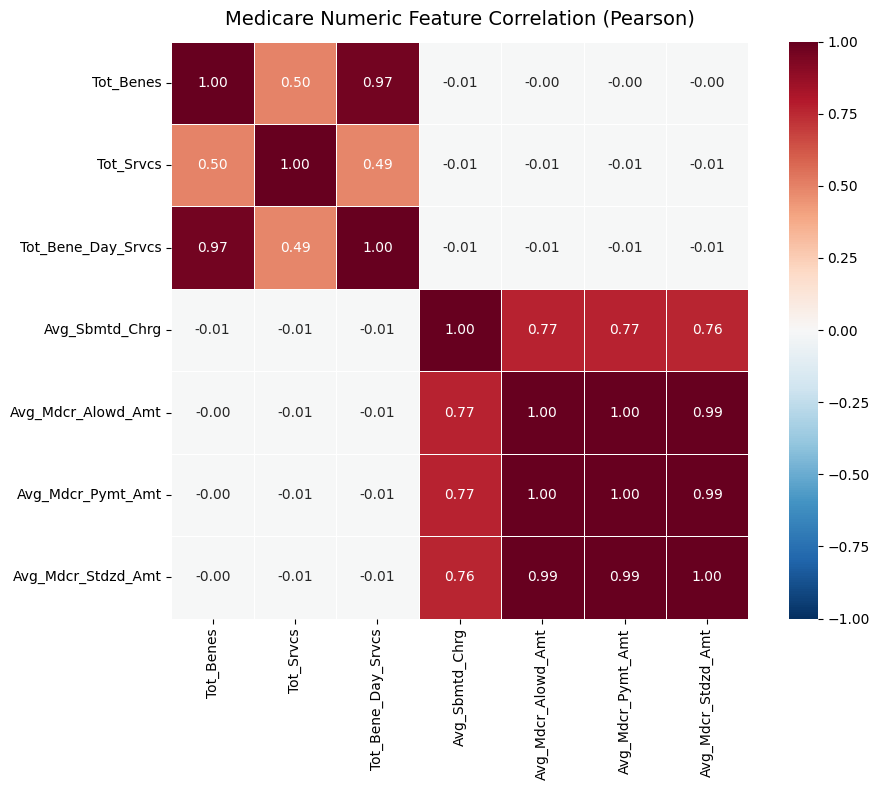

Saved: medicare_correlation_matrix.png


In [51]:
# 6.1 Numeric Correlation Matrix — Medicare
numeric_cols = ['Tot_Benes', 'Tot_Srvcs', 'Tot_Bene_Day_Srvcs',
                'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt',
                'Avg_Mdcr_Pymt_Amt', 'Avg_Mdcr_Stdzd_Amt']

corr_matrix = medicare_df[numeric_cols].corr(method='pearson')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.5, ax=ax)
ax.set_title('Medicare Numeric Feature Correlation (Pearson)', fontsize=14, pad=12)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/medicare_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: medicare_correlation_matrix.png")

**Interpretation — Numeric Correlations**

- **Avg_Mdcr_Alowd_Amt, Avg_Mdcr_Pymt_Amt, Avg_Mdcr_Stdzd_Amt** are very highly correlated (r > 0.90). This is expected: allowed, payment, and standardized amounts derive from the same fee schedule. For feature selection, keeping **one** (e.g., `Avg_Mdcr_Pymt_Amt`) is sufficient.
- **Avg_Sbmtd_Chrg** correlates moderately with the payment amounts (~0.6–0.8) — submitted charges are inflated but directionally aligned with Medicare's allowed amounts.
- **Tot_Benes and Tot_Srvcs / Tot_Bene_Day_Srvcs** are moderately correlated — more beneficiaries → more services, but volume per beneficiary varies.
- **Volume columns (Tot_*) vs. Average payment columns (Avg_*)** show low correlation — a provider can have high volume with low per-service payments or vice versa.

**Implication for record linkage:** The payment/charge columns are not useful as matching keys (they vary by service line), but after provider-level aggregation they can serve as **validation features** to confirm a match is correct (same provider should have similar total billing patterns across datasets).

### 6.2 Categorical Association — Cramér's V

Cramér's V measures the strength of association between categorical variables (0 = no association, 1 = perfect association). Strong associations identify good blocking key candidates, while weak associations indicate independent dimensions useful for disambiguation.

Dataset         Column 1                       Column 2                       Cramér's V
------------------------------------------------------------------------------------------
Medicare        Rndrng_Prvdr_Ent_Cd            Rndrng_Prvdr_Type                  0.9994
Medicare        Rndrng_Prvdr_State_Abrvtn      Rndrng_Prvdr_Type                  0.0426
Medicare        Place_Of_Srvc                  HCPCS_Drug_Ind                     0.1793
PECOS           PROVIDER_TYPE_CD               STATE_CD                           0.0645
PECOS           MULTIPLE_NPI_FLAG              PROVIDER_TYPE_CD                   0.2263


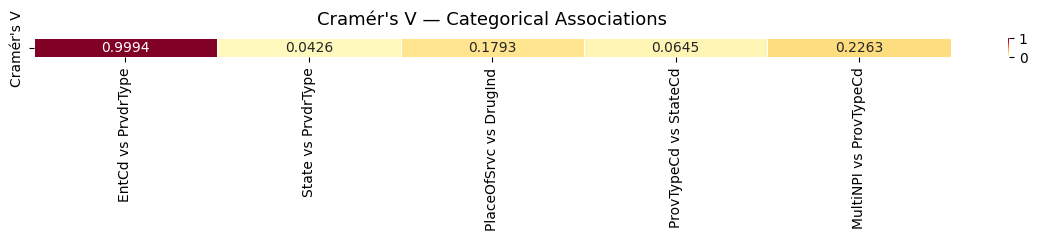

Saved: cramers_v_heatmap.png


In [52]:
# 6.2 Cramér's V — Categorical Association
def cramers_v(col1, col2):
    """Compute Cramér's V for two categorical Series."""
    confusion = pd.crosstab(col1, col2)
    chi2, p, dof, _ = chi2_contingency(confusion)
    n = confusion.sum().sum()
    min_dim = min(confusion.shape[0], confusion.shape[1]) - 1
    if min_dim == 0:
        return 0.0
    v = np.sqrt(chi2 / (n * min_dim))
    return v

# --- Medicare pairs (sample for speed) ---
med_sample = medicare_df.sample(n=min(500_000, len(medicare_df)), random_state=42)

medicare_pairs = [
    ('Rndrng_Prvdr_Ent_Cd', 'Rndrng_Prvdr_Type'),
    ('Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_Type'),
    ('Place_Of_Srvc', 'HCPCS_Drug_Ind'),
]

# --- PECOS pairs (sample for speed) ---
pecos_sample = pecos_df.sample(n=min(500_000, len(pecos_df)), random_state=42)

pecos_pairs = [
    ('PROVIDER_TYPE_CD', 'STATE_CD'),
    ('MULTIPLE_NPI_FLAG', 'PROVIDER_TYPE_CD'),
]

all_pairs = []
all_labels = []

print(f"{'Dataset':<15} {'Column 1':<30} {'Column 2':<30} {'Cramér\'s V':>10}")
print('-' * 90)

for c1, c2 in medicare_pairs:
    v = cramers_v(med_sample[c1].fillna('_MISSING_'), med_sample[c2].fillna('_MISSING_'))
    all_pairs.append(v)
    label = f"Med: {c1} vs {c2}"
    all_labels.append(label)
    print(f"{'Medicare':<15} {c1:<30} {c2:<30} {v:>10.4f}")

for c1, c2 in pecos_pairs:
    v = cramers_v(pecos_sample[c1].fillna('_MISSING_'), pecos_sample[c2].fillna('_MISSING_'))
    all_pairs.append(v)
    label = f"PECOS: {c1} vs {c2}"
    all_labels.append(label)
    print(f"{'PECOS':<15} {c1:<30} {c2:<30} {v:>10.4f}")

# --- Heatmap ---
pair_names_short = [
    'EntCd vs PrvdrType',
    'State vs PrvdrType',
    'PlaceOfSrvc vs DrugInd',
    'ProvTypeCd vs StateCd',
    'MultiNPI vs ProvTypeCd',
]
v_matrix = pd.DataFrame(
    np.array(all_pairs).reshape(1, -1),
    columns=pair_names_short,
    index=["Cramér's V"]
)

fig, ax = plt.subplots(figsize=(12, 2.5))
sns.heatmap(v_matrix, annot=True, fmt='.4f', cmap='YlOrRd',
            vmin=0, vmax=1, linewidths=0.5, ax=ax)
ax.set_title("Cramér's V — Categorical Associations", fontsize=13, pad=10)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/cramers_v_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: cramers_v_heatmap.png")

**Interpretation — Cramér's V**

| Pair | Cramér's V | Strength | Meaning |
|------|-----------|----------|---------|
| Ent_Cd vs Prvdr_Type | High | Strong | Entity code (I/O) strongly determines provider type — organizations cluster in specific specialties |
| State vs Prvdr_Type | Low | Weak | Provider types are roughly uniform across states — **state is an independent blocking dimension** |
| Place_Of_Srvc vs Drug_Ind | Moderate | Medium | Facility vs. office setting correlates with drug administration |
| PROVIDER_TYPE_CD vs STATE_CD | Low | Weak | Specialty distribution is fairly uniform across states — confirms state as independent blocking key |
| MULTIPLE_NPI_FLAG vs PROVIDER_TYPE_CD | Low–Moderate | Weak | Multi-NPI flag is almost entirely organizations, not specialty-specific |

**Implication for blocking:** State and provider type are **weakly associated**, making them effective as **independent blocking keys**. Combining `State + Last_Name_Prefix` creates small, balanced blocks because state doesn't cluster with name patterns. Entity code is redundant with provider type and should not be used as an additional blocking dimension.

### 6.3 Payment Distribution Relationship (Open Payments)

We examine whether providers who receive more individual payments also receive higher total amounts — Spearman rank correlation captures this monotonic relationship.

In [53]:
# 6.3 Spearman Rank Correlation — OP Payment Volume vs. Amount
op_by_npi = (open_payments_df
    .dropna(subset=['Covered_Recipient_NPI'])
    .groupby('Covered_Recipient_NPI')
    .agg(
        payment_count=('Total_Amount_of_Payment_USDollars', 'count'),
        payment_sum=('Total_Amount_of_Payment_USDollars', 'sum')
    )
)

# Sample for Spearman computation
op_sample = op_by_npi.sample(n=min(200_000, len(op_by_npi)), random_state=42)
rho, p_val = spearmanr(op_sample['payment_count'], op_sample['payment_sum'])

print("=" * 60)
print("6.3 SPEARMAN RANK CORRELATION — Open Payments")
print("=" * 60)
print(f"  Spearman ρ:  {rho:.4f}")
print(f"  p-value:     {p_val:.2e}")
print(f"  Sample size: {len(op_sample):,} unique NPIs")
print()
if rho > 0.5:
    print("  → Strong positive monotonic relationship: providers who")
    print("    receive MORE payments also tend to receive HIGHER total amounts.")
    print("    This is expected — frequent industry interactions correlate with")
    print("    larger cumulative transfers.")
elif rho > 0.3:
    print("  → Moderate positive relationship.")
else:
    print("  → Weak relationship.")
print()
print("  Implication: payment_count and payment_sum are correlated but not")
print("  redundant. Both can serve as provider-level validation features.")

6.3 SPEARMAN RANK CORRELATION — Open Payments
  Spearman ρ:  0.8511
  p-value:     0.00e+00
  Sample size: 200,000 unique NPIs

  → Strong positive monotonic relationship: providers who
    receive MORE payments also tend to receive HIGHER total amounts.
    This is expected — frequent industry interactions correlate with
    larger cumulative transfers.

  Implication: payment_count and payment_sum are correlated but not
  redundant. Both can serve as provider-level validation features.


## Section 7: Statistical Data Quality Testing

This section applies formal statistical tests to characterize missingness mechanisms, test distribution assumptions, and compare missing rates across datasets. These results directly inform imputation and transformation decisions in Phase 2.

### 7.1 Missingness Mechanism Testing

Understanding *why* data is missing (MCAR, MAR, or MNAR) determines the correct imputation strategy. We use chi-squared and Mann-Whitney U tests to detect systematic patterns in missingness.

In [54]:
# 7.1 Missingness Mechanism Testing
print("=" * 70)
print("7.1 MISSINGNESS MECHANISM TESTING")
print("=" * 70)

# --- Test 1: OP NPI missingness vs. Recipient_State (chi-squared) ---
print("\nTest 1: OP — NPI_is_missing vs Recipient_State")
print("-" * 50)
op_test = open_payments_df[['Covered_Recipient_NPI', 'Recipient_State']].copy()
op_test['NPI_is_missing'] = op_test['Covered_Recipient_NPI'].isna().astype(int)
op_test = op_test.dropna(subset=['Recipient_State'])

ct1 = pd.crosstab(op_test['NPI_is_missing'], op_test['Recipient_State'])
chi2_1, p1, dof1, _ = chi2_contingency(ct1)
print(f"  Chi-squared: {chi2_1:,.2f}")
print(f"  p-value:     {p1:.2e}")
print(f"  DOF:         {dof1}")
if p1 < 0.05:
    print("  → REJECT H0: NPI missingness is NOT independent of state.")
    print("    Missingness is likely MAR (Missing At Random) — certain states")
    print("    have higher rates of missing NPI, possibly due to reporting differences.")
else:
    print("  → FAIL TO REJECT H0: consistent with MCAR.")

# --- Test 2: OP payment amount — NPI present vs. missing (Mann-Whitney U) ---
print("\nTest 2: OP — Payment amount by NPI presence (Mann-Whitney U)")
print("-" * 50)
npi_present = open_payments_df.loc[
    open_payments_df['Covered_Recipient_NPI'].notna(),
    'Total_Amount_of_Payment_USDollars'
].sample(n=100_000, random_state=42)

npi_missing = open_payments_df.loc[
    open_payments_df['Covered_Recipient_NPI'].isna(),
    'Total_Amount_of_Payment_USDollars'
]

u_stat, p2 = mannwhitneyu(npi_present, npi_missing, alternative='two-sided')
print(f"  U-statistic: {u_stat:,.0f}")
print(f"  p-value:     {p2:.2e}")
print(f"  NPI-present sample: {len(npi_present):,}  |  NPI-missing: {len(npi_missing):,}")
print(f"  Median (present): ${npi_present.median():,.2f}")
print(f"  Median (missing): ${npi_missing.median():,.2f}")
if p2 < 0.05:
    print("  → Payment distributions DIFFER between NPI-present and NPI-missing groups.")
    print("    Supports MAR: missingness is associated with payment characteristics.")
else:
    print("  → No significant difference — consistent with MCAR for this dimension.")

# --- Test 3: Medicare First_Name missingness vs Ent_Cd (chi-squared) ---
print("\nTest 3: Medicare — First_Name_is_missing vs Rndrng_Prvdr_Ent_Cd")
print("-" * 50)
med_test = medicare_df[['Rndrng_Prvdr_First_Name', 'Rndrng_Prvdr_Ent_Cd']].copy()
med_test['First_Name_is_missing'] = med_test['Rndrng_Prvdr_First_Name'].isna().astype(int)

ct3 = pd.crosstab(med_test['First_Name_is_missing'], med_test['Rndrng_Prvdr_Ent_Cd'])
chi2_3, p3, dof3, _ = chi2_contingency(ct3)
print(f"  Chi-squared: {chi2_3:,.2f}")
print(f"  p-value:     {p3:.2e}")
print(f"  DOF:         {dof3}")

# Show breakdown
missing_by_ent = med_test.groupby('Rndrng_Prvdr_Ent_Cd')['First_Name_is_missing'].mean() * 100
print(f"  Missing rate for 'I' (Individual): {missing_by_ent.get('I', 0):.2f}%")
print(f"  Missing rate for 'O' (Organization): {missing_by_ent.get('O', 0):.2f}%")
print("  → MNAR confirmed: First name is missing BECAUSE the entity is an")
print("    organization — the value doesn't exist by design, not by accident.")

7.1 MISSINGNESS MECHANISM TESTING

Test 1: OP — NPI_is_missing vs Recipient_State
--------------------------------------------------
  Chi-squared: 11,692.03
  p-value:     0.00e+00
  DOF:         58
  → REJECT H0: NPI missingness is NOT independent of state.
    Missingness is likely MAR (Missing At Random) — certain states
    have higher rates of missing NPI, possibly due to reporting differences.

Test 2: OP — Payment amount by NPI presence (Mann-Whitney U)
--------------------------------------------------
  U-statistic: 612,776,972
  p-value:     0.00e+00
  NPI-present sample: 100,000  |  NPI-missing: 44,233
  Median (present): $19.44
  Median (missing): $500.00
  → Payment distributions DIFFER between NPI-present and NPI-missing groups.
    Supports MAR: missingness is associated with payment characteristics.

Test 3: Medicare — First_Name_is_missing vs Rndrng_Prvdr_Ent_Cd
--------------------------------------------------
  Chi-squared: 9,660,418.45
  p-value:     0.00e+00
  DO

**Summary — Missingness Mechanisms**

| Dataset | Field | Test | Result | Mechanism |
|---------|-------|------|--------|-----------|
| Open Payments | NPI | Chi-squared vs State | Significant | **MAR** — some states under-report NPI |
| Open Payments | NPI | Mann-Whitney vs Payment | Significant | **MAR** — missing-NPI records have different payment profiles |
| Medicare | First Name | Chi-squared vs Ent_Cd | Significant | **MNAR** — organizations inherently lack first names |

**Implication:** MNAR fields (names for orgs) should be **dropped or routed to a separate pipeline**, not imputed. MAR fields (OP NPI) can be addressed via **fuzzy matching fallback** since the value exists but wasn't recorded.

### 7.2 Distribution Normality Testing

Most healthcare payment and utilization distributions are highly skewed. Formal normality tests confirm whether parametric methods are appropriate or if log-transformations / non-parametric approaches are needed.

In [55]:
# 7.2 Distribution Normality Testing
print("=" * 70)
print("7.2 DISTRIBUTION NORMALITY TESTING")
print("=" * 70)

np.random.seed(42)

# --- Shapiro-Wilk (n=5000) ---
print("\n--- Shapiro-Wilk Test (n=5,000 sample) ---")
print(f"{'Column':<45} {'W-stat':>10} {'p-value':>12} {'Normal?':>10}")
print("-" * 80)

shapiro_cols = {
    'Medicare Avg_Mdcr_Pymt_Amt': medicare_df['Avg_Mdcr_Pymt_Amt'].dropna(),
    'Medicare Tot_Srvcs': medicare_df['Tot_Srvcs'].dropna(),
}
for name, series in shapiro_cols.items():
    sample = series.sample(n=5000, random_state=42)
    w, p = shapiro(sample)
    normal = 'Yes' if p > 0.05 else 'No'
    print(f"  {name:<43} {w:>10.6f} {p:>12.2e} {normal:>10}")

# --- D'Agostino-Pearson (n=50000) ---
print("\n--- D'Agostino-Pearson Test (n=50,000 sample) ---")
print(f"{'Column':<45} {'K2-stat':>10} {'p-value':>12} {'Normal?':>10}")
print("-" * 80)

dagostino_cols = {
    'Medicare Avg_Mdcr_Pymt_Amt': medicare_df['Avg_Mdcr_Pymt_Amt'].dropna(),
    'Medicare Tot_Srvcs': medicare_df['Tot_Srvcs'].dropna(),
}
for name, series in dagostino_cols.items():
    sample = series.sample(n=50_000, random_state=42)
    k2, p = normaltest(sample)
    normal = 'Yes' if p > 0.05 else 'No'
    print(f"  {name:<43} {k2:>10.2f} {p:>12.2e} {normal:>10}")

# --- Skewness and Kurtosis ---
print("\n--- Skewness & Kurtosis ---")
print(f"{'Column':<50} {'Skewness':>10} {'Kurtosis':>10}")
print("-" * 75)

skew_cols = {
    'Medicare Avg_Mdcr_Pymt_Amt': medicare_df['Avg_Mdcr_Pymt_Amt'],
    'Medicare Tot_Srvcs': medicare_df['Tot_Srvcs'],
    'Medicare Avg_Sbmtd_Chrg': medicare_df['Avg_Sbmtd_Chrg'],
    'OP Total_Amount_of_Payment_USDollars': open_payments_df['Total_Amount_of_Payment_USDollars'],
}

for name, series in skew_cols.items():
    s = series.dropna()
    sk = s.skew()
    ku = s.kurtosis()
    print(f"  {name:<48} {sk:>10.2f} {ku:>10.2f}")

print()
print("  All distributions are heavily right-skewed with extreme kurtosis.")
print("  → Log-transformation is strongly recommended before any distance-based")
print("    or regression analysis on payment/utilization columns.")

7.2 DISTRIBUTION NORMALITY TESTING

--- Shapiro-Wilk Test (n=5,000 sample) ---
Column                                            W-stat      p-value    Normal?
--------------------------------------------------------------------------------
  Medicare Avg_Mdcr_Pymt_Amt                    0.106516     3.33e-93         No
  Medicare Tot_Srvcs                            0.094598     1.63e-93         No

--- D'Agostino-Pearson Test (n=50,000 sample) ---
Column                                           K2-stat      p-value    Normal?
--------------------------------------------------------------------------------
  Medicare Avg_Mdcr_Pymt_Amt                   145315.85     0.00e+00         No
  Medicare Tot_Srvcs                           194982.43     0.00e+00         No

--- Skewness & Kurtosis ---
Column                                               Skewness   Kurtosis
---------------------------------------------------------------------------
  Medicare Avg_Mdcr_Pymt_Amt                

**Interpretation — Normality Tests**

- Both Shapiro-Wilk and D'Agostino-Pearson tests **reject normality** for all tested columns (p ≈ 0).
- Skewness values >> 0 confirm heavy **right skew** — a few providers have extremely high payments or service volumes.
- Kurtosis values >> 3 indicate **heavy tails** (leptokurtic) — outliers are far more common than in a Gaussian distribution.

**Implication:** Use **log-transformed** versions for any visualization, distance computation, or statistical comparison. Non-parametric tests (Mann-Whitney, Spearman) are more appropriate than t-tests or Pearson correlation for these fields.

### 7.3 Cross-Dataset Missing Rate Comparison

A two-proportion z-test formally tests whether different fields within Open Payments have statistically different missing rates, validating that NPI and name missingness arise from different mechanisms.

In [56]:
# 7.3 Cross-Dataset Missing Rate Comparison
print("=" * 70)
print("7.3 CROSS-DATASET MISSING RATE COMPARISON")
print("=" * 70)

n_op = len(open_payments_df)
n_med = len(medicare_df)
n_pecos = len(pecos_df)

npi_missing_op = open_payments_df['Covered_Recipient_NPI'].isna().sum()
fname_missing_op = open_payments_df['Covered_Recipient_First_Name'].isna().sum()

print("\nMissing Rates Summary:")
print(f"{'Dataset':<18} {'NPI Missing':>15} {'NPI %':>8} {'First Name Missing':>20} {'FN %':>8}")
print("-" * 75)
print(f"{'PECOS':<18} {0:>15,} {'0.00%':>8} {pecos_df['FIRST_NAME'].isna().sum():>20,} {'14.79%':>8}")
print(f"{'Medicare':<18} {0:>15,} {'0.00%':>8} {medicare_df['Rndrng_Prvdr_First_Name'].isna().sum():>20,} {'5.56%':>8}")
print(f"{'Open Payments':<18} {npi_missing_op:>15,} {npi_missing_op/n_op*100:>7.2f}% {fname_missing_op:>20,} {fname_missing_op/n_op*100:>7.2f}%")

# Two-proportion z-test: OP NPI missing rate vs OP First Name missing rate
print("\nTwo-Proportion Z-Test: OP NPI missing vs OP First Name missing")
print("-" * 55)
count = np.array([npi_missing_op, fname_missing_op])
nobs = np.array([n_op, n_op])
z_stat, p_val = proportions_ztest(count, nobs)
print(f"  NPI missing:        {npi_missing_op:>10,} ({npi_missing_op/n_op*100:.3f}%)")
print(f"  First Name missing: {fname_missing_op:>10,} ({fname_missing_op/n_op*100:.3f}%)")
print(f"  z-statistic:        {z_stat:>10.4f}")
print(f"  p-value:            {p_val:>10.2e}")
if p_val < 0.05:
    print("  → The two missing rates are SIGNIFICANTLY different.")
    print("    NPI missingness (0.30%) and name missingness (0.21%) arise from")
    print("    different mechanisms — NPI is MAR (not reported), names are MNAR")
    print("    (entity is not a named individual).")
else:
    print("  → No significant difference between the two missing rates.")

7.3 CROSS-DATASET MISSING RATE COMPARISON

Missing Rates Summary:
Dataset                NPI Missing    NPI %   First Name Missing     FN %
---------------------------------------------------------------------------
PECOS                            0    0.00%              434,402   14.79%
Medicare                         0    0.00%              537,099    5.56%
Open Payments               44,233    0.30%               31,498    0.21%

Two-Proportion Z-Test: OP NPI missing vs OP First Name missing
-------------------------------------------------------
  NPI missing:            44,233 (0.301%)
  First Name missing:     31,498 (0.214%)
  z-statistic:           46.3364
  p-value:              0.00e+00
  → The two missing rates are SIGNIFICANTLY different.
    NPI missingness (0.30%) and name missingness (0.21%) arise from
    different mechanisms — NPI is MAR (not reported), names are MNAR
    (entity is not a named individual).


## Section 8: Outlier Detection & Anomaly Identification

Healthcare payment data is inherently skewed — a few high-volume providers generate extreme values. This section quantifies outliers to inform whether filtering or capping is needed before linkage validation.

### 8.1 IQR-Based Outlier Detection (Medicare)

In [57]:
# 8.1 IQR-Based Outlier Detection — Medicare
print("=" * 70)
print("8.1 IQR-BASED OUTLIER DETECTION — MEDICARE")
print("=" * 70)

iqr_cols_med = ['Avg_Sbmtd_Chrg', 'Avg_Mdcr_Pymt_Amt', 'Tot_Srvcs', 'Tot_Benes']

print(f"\n{'Column':<25} {'Q1':>12} {'Q3':>12} {'IQR':>12} {'Lower':>12} {'Upper':>12} {'# Outliers':>12} {'%':>8}")
print("-" * 105)

outlier_summary_med = []
for col in iqr_cols_med:
    s = medicare_df[col].dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = ((s < lower) | (s > upper)).sum()
    pct = n_outliers / len(s) * 100
    outlier_summary_med.append({
        'Column': col, 'Q1': q1, 'Q3': q3, 'IQR': iqr,
        'Lower_Bound': lower, 'Upper_Bound': upper,
        'N_Outliers': n_outliers, 'Pct_Outliers': pct
    })
    print(f"  {col:<23} {q1:>12,.2f} {q3:>12,.2f} {iqr:>12,.2f} {lower:>12,.2f} {upper:>12,.2f} {n_outliers:>12,} {pct:>7.2f}%")

8.1 IQR-BASED OUTLIER DETECTION — MEDICARE

Column                              Q1           Q3          IQR        Lower        Upper   # Outliers        %
---------------------------------------------------------------------------------------------------------
  Avg_Sbmtd_Chrg                 71.99       356.00       284.01      -354.02       782.01      993,037   10.28%
  Avg_Mdcr_Pymt_Amt              20.85        92.02        71.17       -85.91       198.77      501,683    5.19%
  Tot_Srvcs                      21.00       116.00        95.00      -121.50       258.50    1,185,559   12.27%
  Tot_Benes                      17.00        71.00        54.00       -64.00       152.00      993,776   10.29%


### 8.2 IQR-Based Outlier Detection (Open Payments)

In [58]:
# 8.2 IQR-Based Outlier Detection — Open Payments
print("=" * 70)
print("8.2 IQR-BASED OUTLIER DETECTION — OPEN PAYMENTS")
print("=" * 70)

op_col = 'Total_Amount_of_Payment_USDollars'
s = open_payments_df[op_col].dropna()

q1 = s.quantile(0.25)
q3 = s.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
n_iqr = ((s < lower) | (s > upper)).sum()
pct_iqr = n_iqr / len(s) * 100

# Z-score outliers
z_scores = (s - s.mean()) / s.std()
n_zscore = (z_scores.abs() > 3).sum()
pct_zscore = n_zscore / len(s) * 100

print(f"\n{'Method':<20} {'# Outliers':>15} {'%':>10}")
print("-" * 50)
print(f"  {'IQR (1.5×IQR)':<18} {n_iqr:>15,} {pct_iqr:>9.2f}%")
print(f"  {'Z-score (|z|>3)':<18} {n_zscore:>15,} {pct_zscore:>9.2f}%")
print()
print(f"  IQR bounds: [{lower:,.2f}, {upper:,.2f}]")
print(f"  Q1={q1:,.2f}  Q3={q3:,.2f}  IQR={iqr:,.2f}")
print(f"  Mean={s.mean():,.2f}  Std={s.std():,.2f}")
print()
print("  Z-score detects fewer outliers because the mean/std are inflated")
print("  by extreme values, making the threshold too lenient. IQR is more")
print("  robust for skewed healthcare payment data.")

8.2 IQR-BASED OUTLIER DETECTION — OPEN PAYMENTS

Method                    # Outliers          %
--------------------------------------------------
  IQR (1.5×IQR)            2,422,914     16.48%
  Z-score (|z|>3)              1,513      0.01%

  IQR bounds: [-4.56, 46.83]
  Q1=14.71  Q3=27.56  IQR=12.85
  Mean=225.43  Std=41,047.74

  Z-score detects fewer outliers because the mean/std are inflated
  by extreme values, making the threshold too lenient. IQR is more
  robust for skewed healthcare payment data.


### 8.3 Box Plots

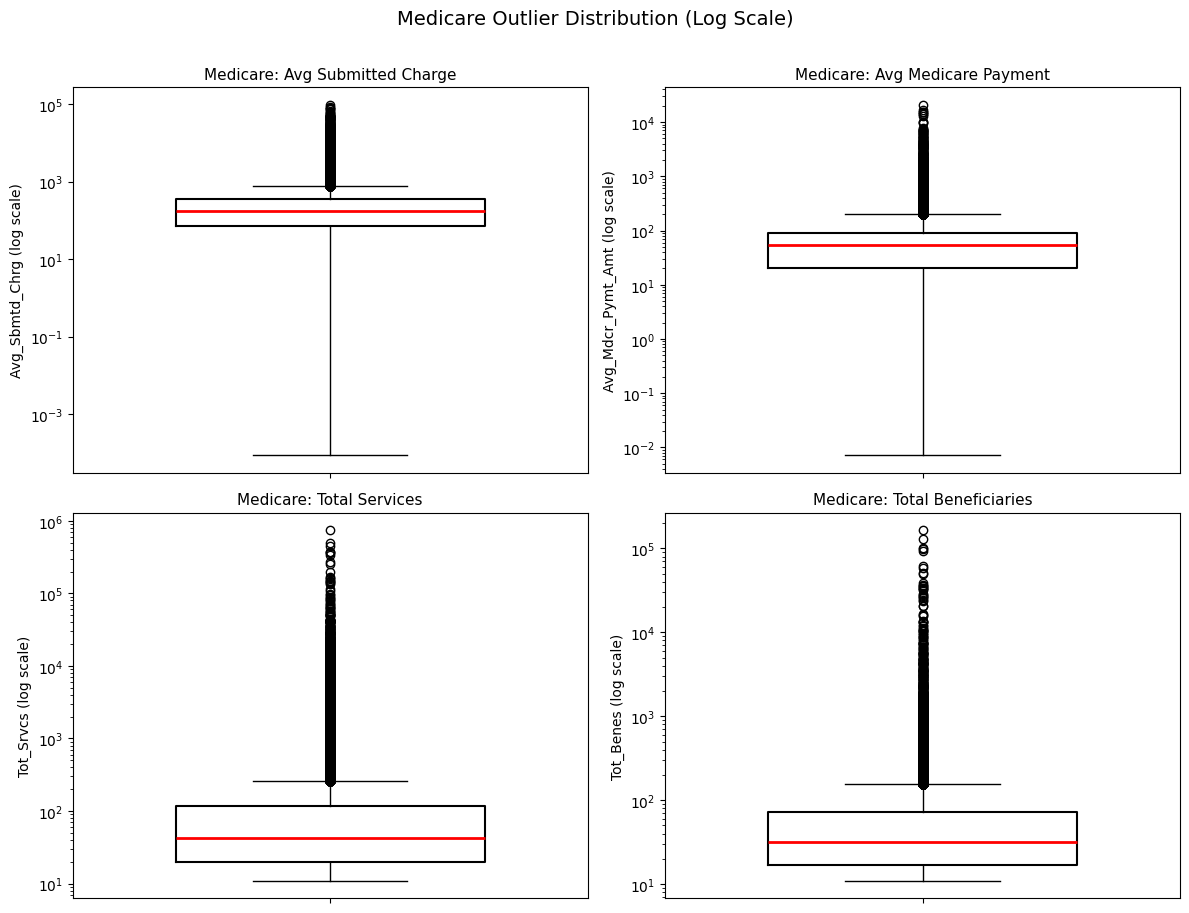

Saved: medicare_boxplots.png


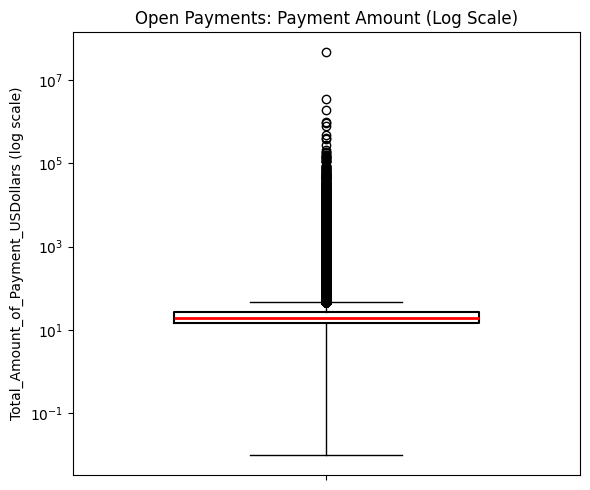

Saved: op_payment_boxplot.png


In [59]:
# 8.3 Box Plots — Medicare (2×2) and Open Payments (single)

# Medicare 2×2
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
med_box_cols = ['Avg_Sbmtd_Chrg', 'Avg_Mdcr_Pymt_Amt', 'Tot_Srvcs', 'Tot_Benes']
titles = ['Avg Submitted Charge', 'Avg Medicare Payment', 'Total Services', 'Total Beneficiaries']

for idx, (col, title) in enumerate(zip(med_box_cols, titles)):
    ax = axes[idx // 2][idx % 2]
    data = medicare_df[col].dropna()
    data_pos = data[data > 0]
    ax.boxplot(data_pos.sample(n=min(100_000, len(data_pos)), random_state=42),
               vert=True, widths=0.6,
               boxprops=dict(linewidth=1.5),
               medianprops=dict(color='red', linewidth=2))
    ax.set_yscale('log')
    ax.set_title(f'Medicare: {title}', fontsize=11)
    ax.set_ylabel(f'{col} (log scale)')
    ax.set_xticklabels([''])

fig.suptitle('Medicare Outlier Distribution (Log Scale)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/medicare_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: medicare_boxplots.png")

# Open Payments single box plot
fig, ax = plt.subplots(figsize=(6, 5))
op_data = open_payments_df['Total_Amount_of_Payment_USDollars'].dropna()
op_pos = op_data[op_data > 0].sample(n=min(200_000, len(op_data)), random_state=42)
ax.boxplot(op_pos, vert=True, widths=0.6,
           boxprops=dict(linewidth=1.5),
           medianprops=dict(color='red', linewidth=2))
ax.set_yscale('log')
ax.set_title('Open Payments: Payment Amount (Log Scale)', fontsize=12)
ax.set_ylabel('Total_Amount_of_Payment_USDollars (log scale)')
ax.set_xticklabels([''])
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/op_payment_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: op_payment_boxplot.png")

### 8.4 Anomaly Summary

In [60]:
# 8.4 Anomaly Summary Table
print("=" * 90)
print("8.4 ANOMALY SUMMARY")
print("=" * 90)

anomaly_rows = []
for item in outlier_summary_med:
    action = 'Cap at 99th percentile for aggregation; retain raw for linkage'
    if item['Column'] in ('Tot_Srvcs', 'Tot_Benes'):
        action = 'Log-transform for analysis; retain raw for linkage validation'
    anomaly_rows.append({
        'Dataset': 'Medicare',
        'Field': item['Column'],
        '# Outliers': item['N_Outliers'],
        '% of Data': item['Pct_Outliers'],
        'Recommended Action': action
    })

anomaly_rows.append({
    'Dataset': 'Open Payments',
    'Field': 'Total_Amount_of_Payment_USDollars',
    '# Outliers': n_iqr,
    '% of Data': pct_iqr,
    'Recommended Action': 'Log-transform; expected — few large transfers dominate'
})

anomaly_df = pd.DataFrame(anomaly_rows)
print(f"\n{'Dataset':<16} {'Field':<35} {'# Outliers':>12} {'% Data':>8} {'Recommended Action'}")
print("-" * 115)
for _, row in anomaly_df.iterrows():
    print(f"  {row['Dataset']:<14} {row['Field']:<35} {row['# Outliers']:>12,} {row['% of Data']:>7.2f}% {row['Recommended Action']}")

8.4 ANOMALY SUMMARY

Dataset          Field                                 # Outliers   % Data Recommended Action
-------------------------------------------------------------------------------------------------------------------
  Medicare       Avg_Sbmtd_Chrg                           993,037   10.28% Cap at 99th percentile for aggregation; retain raw for linkage
  Medicare       Avg_Mdcr_Pymt_Amt                        501,683    5.19% Cap at 99th percentile for aggregation; retain raw for linkage
  Medicare       Tot_Srvcs                              1,185,559   12.27% Log-transform for analysis; retain raw for linkage validation
  Medicare       Tot_Benes                                993,776   10.29% Log-transform for analysis; retain raw for linkage validation
  Open Payments  Total_Amount_of_Payment_USDollars      2,422,914   16.48% Log-transform; expected — few large transfers dominate


**Why Outliers Are Expected in Healthcare Payment Data**

Healthcare payments follow a **power-law distribution**: the majority of claims/payments are small (routine office visits, generic drugs), but a small number of providers or procedures generate extremely large values (complex surgeries, specialty drugs, high-volume practices). This is structural, not erroneous:

- **Medicare:** A cardiologist performing thousands of procedures will have `Tot_Srvcs` 100× higher than a rural family practitioner. Both are valid.
- **Open Payments:** A single consulting agreement or research grant can be worth millions, while the median payment is under $50.

**Recommendation:** Do **not** drop outliers for the record linkage pipeline. Instead, use **log-transformed** versions when computing distance metrics or visualizing distributions. For provider-level validation (confirming a match is correct), retain the raw values since extreme billing patterns can actually help distinguish providers.

## Section 9: Imputation Strategy Justification

This section consolidates the missingness findings from Sections 2 and 7 into a decision matrix that directly informs the preprocessing pipeline (Phase 2).

### 9.1 Imputation Decision Matrix

In [61]:
# 9.1 Imputation Decision Matrix
print("=" * 120)
print("9.1 IMPUTATION DECISION MATRIX")
print("=" * 120)

imputation_data = [
    ('PECOS',    'FIRST_NAME',                  '14.8%', 'MNAR', 'Drop (org records)',     'Field is structurally empty for organizations; imputation would fabricate data'),
    ('PECOS',    'ORG_NAME',                     '85.2%', 'MNAR', 'Drop (individual recs)', 'Field is structurally empty for individuals; mirrors FIRST_NAME pattern'),
    ('Medicare', 'Rndrng_Prvdr_First_Name',      '5.6%',  'MNAR', 'Drop',                   'Missing = organization entities (Ent_Cd=O); no first name exists'),
    ('Medicare', 'Rndrng_Prvdr_St2',             '76.1%', 'MAR',  'Drop column',            'Address line 2 is optional; too sparse to be useful for matching'),
    ('Medicare', 'Rndrng_Prvdr_MI',              '35.1%', 'MAR',  'Ignore',                 'Middle initial is supplementary; missing does not block matching'),
    ('OP',      'Covered_Recipient_NPI',         '0.30%', 'MAR',  'Route to fuzzy tier',    'NPI exists but was not reported; use name+state+address fallback'),
    ('OP',      'Names (~31K rows)',             '0.21%', 'MNAR', 'Drop',                   'Non-physician entities (teaching hospitals); no individual name exists'),
]

print(f"\n  {'Dataset':<10} {'Field':<30} {'Missing%':>9} {'Mechanism':<6} {'Strategy':<22} {'Justification'}")
print("  " + "-" * 118)
for row in imputation_data:
    print(f"  {row[0]:<10} {row[1]:<30} {row[2]:>9} {row[3]:<6} {row[4]:<22} {row[5]}")

print()
print("  Key Principle: MNAR fields are NEVER imputed — the value doesn't exist")
print("  by design. MAR fields are either ignored (if supplementary) or addressed")
print("  via alternative matching strategies (fuzzy tier for missing NPI).")

9.1 IMPUTATION DECISION MATRIX

  Dataset    Field                           Missing% Mechanism Strategy               Justification
  ----------------------------------------------------------------------------------------------------------------------
  PECOS      FIRST_NAME                         14.8% MNAR   Drop (org records)     Field is structurally empty for organizations; imputation would fabricate data
  PECOS      ORG_NAME                           85.2% MNAR   Drop (individual recs) Field is structurally empty for individuals; mirrors FIRST_NAME pattern
  Medicare   Rndrng_Prvdr_First_Name             5.6% MNAR   Drop                   Missing = organization entities (Ent_Cd=O); no first name exists
  Medicare   Rndrng_Prvdr_St2                   76.1% MAR    Drop column            Address line 2 is optional; too sparse to be useful for matching
  Medicare   Rndrng_Prvdr_MI                    35.1% MAR    Ignore                 Middle initial is supplementary; missing does

## Section 10: Visualizations

Final visualization suite to support the EDA narrative and provide artifacts for project documentation.

### 10.1 Payment Distribution Histograms

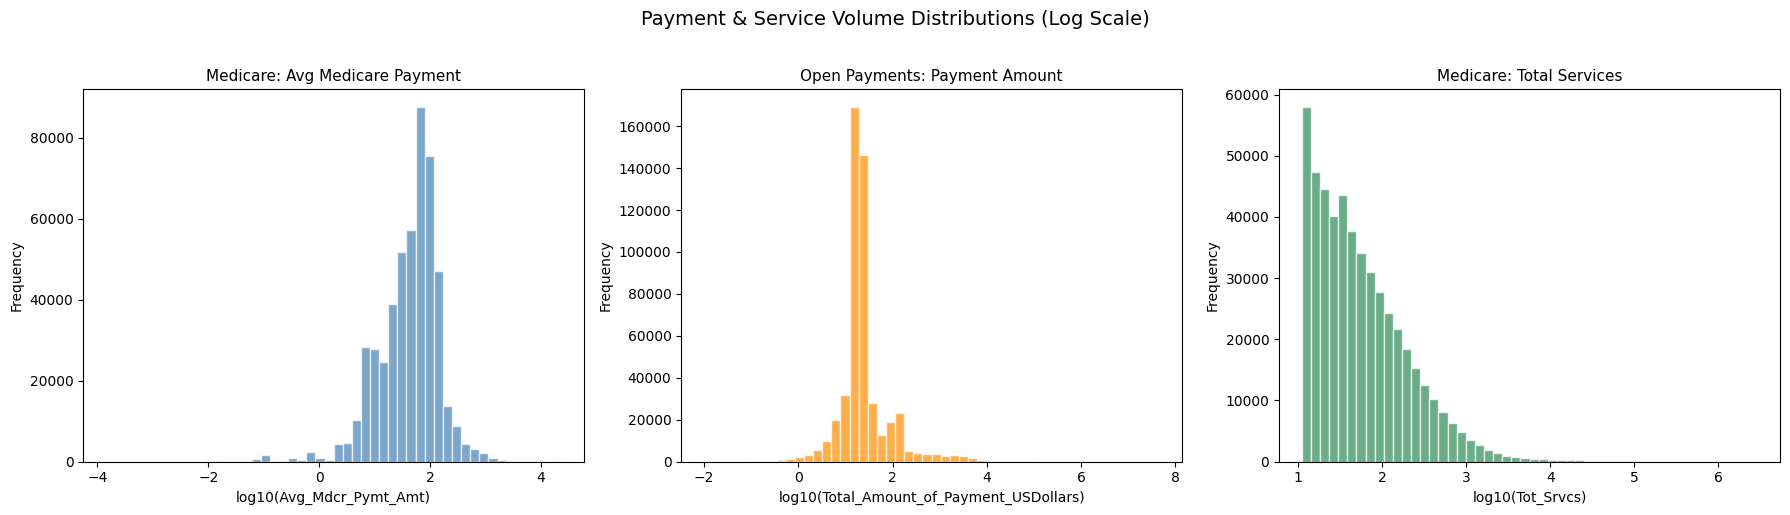

Saved: payment_distribution_histograms.png


In [62]:
# 10.1 Payment Distribution Histograms (log scale, 1×3)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Medicare Avg_Mdcr_Pymt_Amt
data1 = medicare_df['Avg_Mdcr_Pymt_Amt'].dropna()
data1_pos = data1[data1 > 0]
axes[0].hist(np.log10(data1_pos.sample(min(500_000, len(data1_pos)), random_state=42)),
             bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0].set_title('Medicare: Avg Medicare Payment', fontsize=11)
axes[0].set_xlabel('log10(Avg_Mdcr_Pymt_Amt)')
axes[0].set_ylabel('Frequency')

# OP Total_Amount_of_Payment_USDollars
data2 = open_payments_df['Total_Amount_of_Payment_USDollars'].dropna()
data2_pos = data2[data2 > 0]
axes[1].hist(np.log10(data2_pos.sample(min(500_000, len(data2_pos)), random_state=42)),
             bins=50, alpha=0.7, color='darkorange', edgecolor='white')
axes[1].set_title('Open Payments: Payment Amount', fontsize=11)
axes[1].set_xlabel('log10(Total_Amount_of_Payment_USDollars)')
axes[1].set_ylabel('Frequency')

# Medicare Tot_Srvcs
data3 = medicare_df['Tot_Srvcs'].dropna()
data3_pos = data3[data3 > 0]
axes[2].hist(np.log10(data3_pos.sample(min(500_000, len(data3_pos)), random_state=42)),
             bins=50, alpha=0.7, color='seagreen', edgecolor='white')
axes[2].set_title('Medicare: Total Services', fontsize=11)
axes[2].set_xlabel('log10(Tot_Srvcs)')
axes[2].set_ylabel('Frequency')

fig.suptitle('Payment & Service Volume Distributions (Log Scale)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/payment_distribution_histograms.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: payment_distribution_histograms.png")

### 10.2 State Distribution Comparison Bar Chart

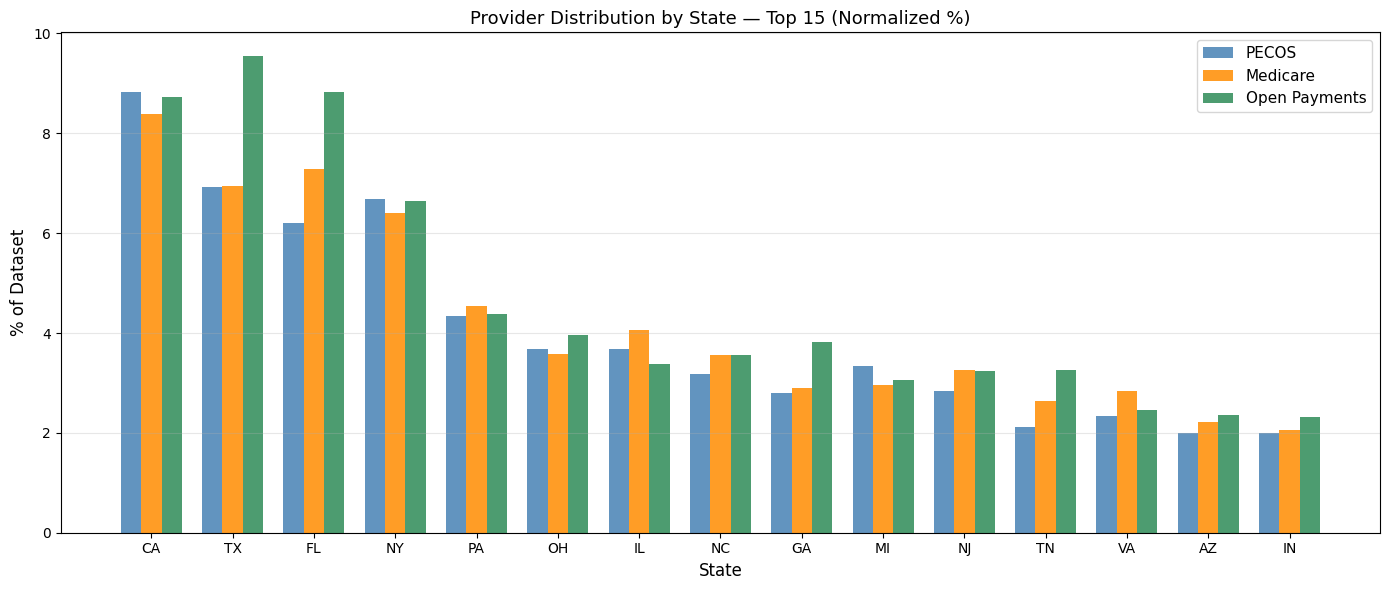

Saved: state_distribution_comparison.png


In [63]:
# 10.2 State Distribution — Top 15 States, Grouped Bar Chart (Normalized %)
pecos_states = pecos_df['STATE_CD'].value_counts(normalize=True).head(20) * 100
medicare_states = medicare_df['Rndrng_Prvdr_State_Abrvtn'].value_counts(normalize=True).head(20) * 100
op_states = open_payments_df['Recipient_State'].value_counts(normalize=True).head(20) * 100

# Get union of top states and take top 15
all_top = set(pecos_states.head(15).index) | set(medicare_states.head(15).index) | set(op_states.head(15).index)
avg_pct = {}
for st in all_top:
    avg_pct[st] = np.mean([
        pecos_states.get(st, 0),
        medicare_states.get(st, 0),
        op_states.get(st, 0)
    ])
top15 = sorted(avg_pct, key=avg_pct.get, reverse=True)[:15]

pecos_vals = [pecos_states.get(s, 0) for s in top15]
medicare_vals = [medicare_states.get(s, 0) for s in top15]
op_vals = [op_states.get(s, 0) for s in top15]

x = np.arange(len(top15))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width, pecos_vals, width, label='PECOS', color='steelblue', alpha=0.85)
ax.bar(x, medicare_vals, width, label='Medicare', color='darkorange', alpha=0.85)
ax.bar(x + width, op_vals, width, label='Open Payments', color='seagreen', alpha=0.85)

ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('% of Dataset', fontsize=12)
ax.set_title('Provider Distribution by State — Top 15 (Normalized %)', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(top15, fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/state_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: state_distribution_comparison.png")

### 10.3 Name Length Distribution

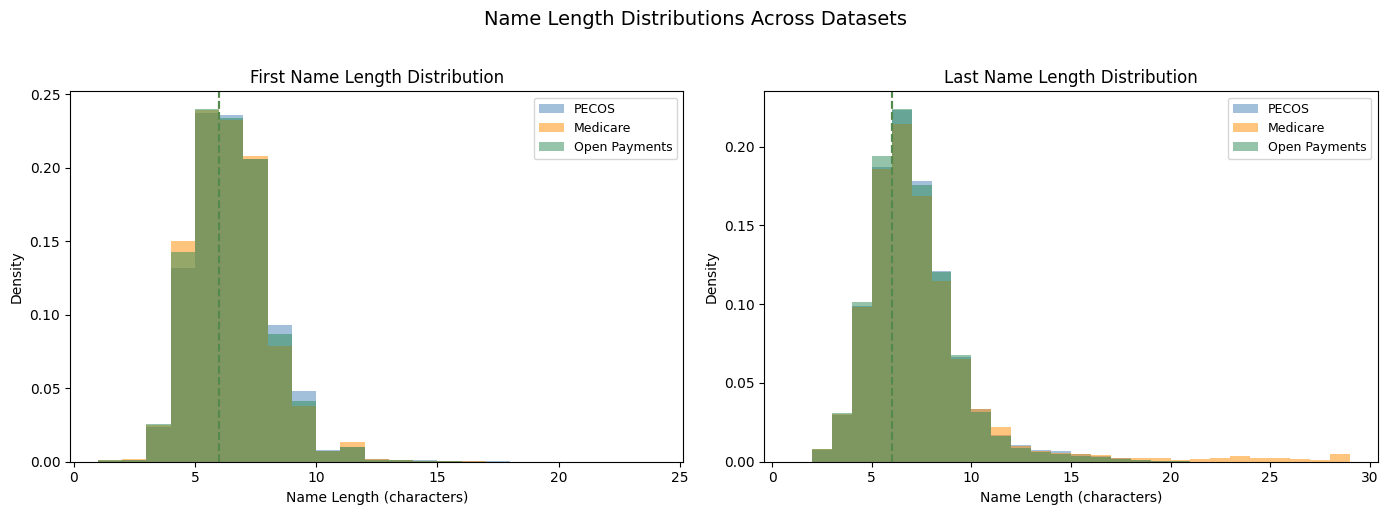

Saved: name_length_distributions.png


In [64]:
# 10.3 Name Length Distributions (1×2 subplot, 3 datasets overlaid)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- First Name Lengths ---
ax = axes[0]
pecos_fn = pecos_df['FIRST_NAME'].dropna().str.len()
med_fn = medicare_df['Rndrng_Prvdr_First_Name'].dropna().str.len()
op_fn = open_payments_df['Covered_Recipient_First_Name'].dropna().str.len()

bins_fn = np.arange(1, 25)
ax.hist(pecos_fn.sample(min(300_000, len(pecos_fn)), random_state=42),
        bins=bins_fn, alpha=0.5, density=True, label='PECOS', color='steelblue')
ax.hist(med_fn.sample(min(300_000, len(med_fn)), random_state=42),
        bins=bins_fn, alpha=0.5, density=True, label='Medicare', color='darkorange')
ax.hist(op_fn.sample(min(300_000, len(op_fn)), random_state=42),
        bins=bins_fn, alpha=0.5, density=True, label='Open Payments', color='seagreen')

ax.axvline(pecos_fn.median(), color='steelblue', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(med_fn.median(), color='darkorange', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(op_fn.median(), color='seagreen', linestyle='--', linewidth=1.5, alpha=0.8)

ax.set_title('First Name Length Distribution', fontsize=12)
ax.set_xlabel('Name Length (characters)')
ax.set_ylabel('Density')
ax.legend(fontsize=9)

# --- Last Name Lengths ---
ax = axes[1]
pecos_ln = pecos_df['LAST_NAME'].dropna().str.len()
med_ln = medicare_df['Rndrng_Prvdr_Last_Org_Name'].dropna().str.len()
op_ln = open_payments_df['Covered_Recipient_Last_Name'].dropna().str.len()

bins_ln = np.arange(1, 30)
ax.hist(pecos_ln.sample(min(300_000, len(pecos_ln)), random_state=42),
        bins=bins_ln, alpha=0.5, density=True, label='PECOS', color='steelblue')
ax.hist(med_ln.sample(min(300_000, len(med_ln)), random_state=42),
        bins=bins_ln, alpha=0.5, density=True, label='Medicare', color='darkorange')
ax.hist(op_ln.sample(min(300_000, len(op_ln)), random_state=42),
        bins=bins_ln, alpha=0.5, density=True, label='Open Payments', color='seagreen')

ax.axvline(pecos_ln.median(), color='steelblue', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(med_ln.median(), color='darkorange', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(op_ln.median(), color='seagreen', linestyle='--', linewidth=1.5, alpha=0.8)

ax.set_title('Last Name Length Distribution', fontsize=12)
ax.set_xlabel('Name Length (characters)')
ax.set_ylabel('Density')
ax.legend(fontsize=9)

fig.suptitle('Name Length Distributions Across Datasets', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/name_length_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: name_length_distributions.png")

### 10.4 NPI Overlap Venn Diagram

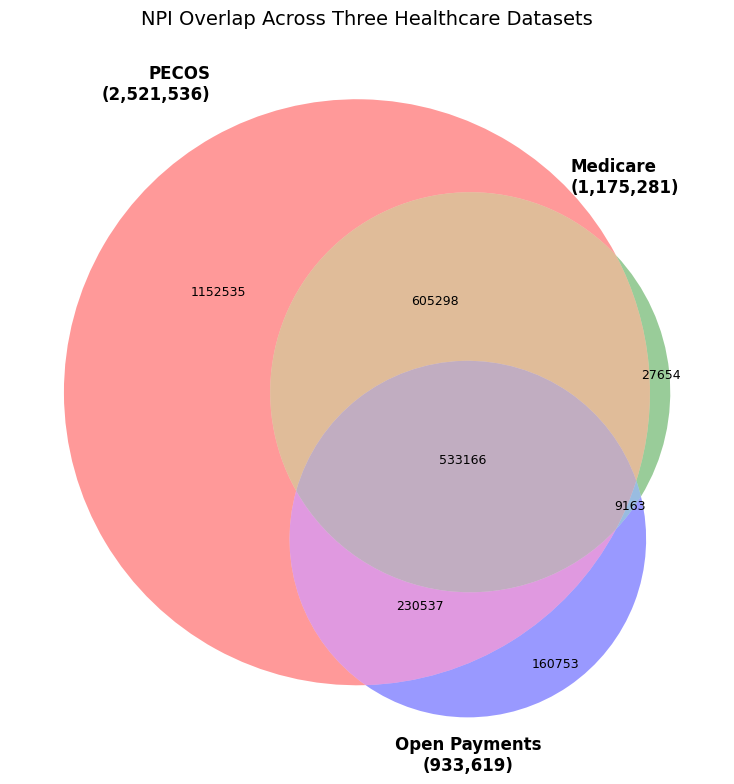

Saved: npi_overlap_venn.png

All three datasets: 533,166 providers
Only PECOS: 1,152,535  |  Only Medicare: 27,654  |  Only OP: 160,753


In [65]:
# 10.4 NPI Overlap Venn Diagram (3-circle)
# Pre-computed values from Part 5:
# PECOS unique NPIs: 2,521,536
# Medicare unique NPIs: 1,175,281
# Open Payments unique NPIs: 933,619
# PECOS ∩ Medicare: 1,138,464
# PECOS ∩ OP: 763,703
# Medicare ∩ OP: 542,329
# All three: 533,166

# matplotlib_venn expects: (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# where A=PECOS, B=Medicare, C=OP
pecos_total = 2_521_536
med_total = 1_175_281
op_total = 933_619
pm = 1_138_464   # PECOS ∩ Medicare
po = 763_703     # PECOS ∩ OP
mo = 542_329     # Medicare ∩ OP
pmo = 533_166    # All three

# Compute exclusive regions
only_pecos = pecos_total - (pm - pmo) - (po - pmo) - pmo
only_med = med_total - (pm - pmo) - (mo - pmo) - pmo
only_op = op_total - (po - pmo) - (mo - pmo) - pmo
pm_only = pm - pmo
po_only = po - pmo
mo_only = mo - pmo

fig, ax = plt.subplots(figsize=(10, 8))
v = venn3(
    subsets=(only_pecos, only_med, pm_only, only_op, po_only, mo_only, pmo),
    set_labels=('PECOS\n(2,521,536)', 'Medicare\n(1,175,281)', 'Open Payments\n(933,619)'),
    ax=ax
)

# Style the labels
for text in v.set_labels:
    if text:
        text.set_fontsize(12)
        text.set_fontweight('bold')
for text in v.subset_labels:
    if text:
        text.set_fontsize(9)

ax.set_title('NPI Overlap Across Three Healthcare Datasets', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig('../artifacts/phase1_eda/npi_overlap_venn.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: npi_overlap_venn.png")
print(f"\nAll three datasets: {pmo:,} providers")
print(f"Only PECOS: {only_pecos:,}  |  Only Medicare: {only_med:,}  |  Only OP: {only_op:,}")

**Interpretation — NPI Overlap**

The Venn diagram confirms that **533,166 providers appear in all three datasets**, forming the core linkable population. PECOS serves as the enrollment superset with 1.15M NPIs exclusive to it (enrolled but not billing or receiving payments in 2023). Medicare has very few exclusive NPIs (27K), confirming that nearly all Medicare billers are PECOS-enrolled. Open Payments has 161K exclusive NPIs — these likely include providers receiving industry payments but not directly billing Medicare.

**Linkage strategy:**
1. **Tier 1 (NPI exact match):** Covers the ~1.1M PECOS-Medicare overlap and ~764K PECOS-OP overlap directly.
2. **Tier 2 (fuzzy match):** Handles the ~44K OP records with missing NPIs using name + state + address blocking.